In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statsmodels.graphics.mosaicplot import mosaic
import imblearn
import xgboost as xgb
import lightgbm as lgb
import shap

print("Libraries installed and imported successfully.")


Libraries installed and imported successfully.


In [2]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)


# Reading the datasets

In [3]:
train_df = pd.read_csv('train_dataset_final1.csv')
validation_df = pd.read_csv('validate_dataset_final.csv')

In [4]:
print("Train shape:", train_df.shape)
print("Validation shape:", validation_df.shape)

Train shape: (25247, 27)
Validation shape: (5016, 26)


In [5]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25247 entries, 0 to 25246
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         25247 non-null  int64  
 1   marriage            25247 non-null  int64  
 2   sex                 25247 non-null  int64  
 3   education           25247 non-null  int64  
 4   LIMIT_BAL           25247 non-null  int64  
 5   age                 25121 non-null  float64
 6   pay_0               25247 non-null  int64  
 7   pay_2               25247 non-null  int64  
 8   pay_3               25247 non-null  int64  
 9   pay_4               25247 non-null  int64  
 10  pay_5               25247 non-null  int64  
 11  pay_6               25247 non-null  int64  
 12  Bill_amt1           25247 non-null  float64
 13  Bill_amt2           25247 non-null  float64
 14  Bill_amt3           25247 non-null  float64
 15  Bill_amt4           25247 non-null  float64
 16  Bill

# Checking for Possible Null Values in Datasets

In [6]:
print(train_df.isnull().sum())

Customer_ID             0
marriage                0
sex                     0
education               0
LIMIT_BAL               0
age                   126
pay_0                   0
pay_2                   0
pay_3                   0
pay_4                   0
pay_5                   0
pay_6                   0
Bill_amt1               0
Bill_amt2               0
Bill_amt3               0
Bill_amt4               0
Bill_amt5               0
Bill_amt6               0
pay_amt1                0
pay_amt2                0
pay_amt3                0
pay_amt4                0
pay_amt5                0
pay_amt6                0
AVG_Bill_amt            0
PAY_TO_BILL_ratio       0
next_month_default      0
dtype: int64


Here, we see only age has some missing/null values. The missing values can be replaced by the median.

In [7]:
median_age = train_df['age'].median()
train_df['age'] = train_df['age'].fillna(median_age)

In [8]:
train_df['age'].isnull().sum()

0

In [9]:
print(validation_df.isnull().sum())

Customer_ID          0
marriage             0
sex                  0
education            0
LIMIT_BAL            0
age                  0
pay_0                0
pay_2                0
pay_3                0
pay_4                0
pay_5                0
pay_6                0
Bill_amt1            0
Bill_amt2            0
Bill_amt3            0
Bill_amt4            0
Bill_amt5            0
Bill_amt6            0
pay_amt1             0
pay_amt2             0
pay_amt3             0
pay_amt4             0
pay_amt5             0
pay_amt6             0
AVG_Bill_amt         0
PAY_TO_BILL_ratio    0
dtype: int64


No nulls are present in validation dataset

# Checking For Duplicate Rows

In [10]:
print('Number of duplicate rows in training dataset:')
print(train_df.duplicated().sum())

Number of duplicate rows in training dataset:
0


In [11]:
print('Number of duplicate rows in training dataset:')
print(validation_df.duplicated().sum())

Number of duplicate rows in training dataset:
0


# Checking For Invalid Entries (Categorical)



In [12]:
# Check unique values and invalid entries
cat_columns = ['marriage', 'sex', 'education']
expected_values = {
    'marriage': [1, 2, 3],
    'sex': [0, 1],
    'education': [1, 2, 3, 4]
}

for col in cat_columns:
    print(f"{col} unique values in training dataset: {train_df[col].unique()}")

marriage unique values in training dataset: [2 1 3 0]
sex unique values in training dataset: [0 1]
education unique values in training dataset: [2 1 3 4 5 6 0]


In [13]:
cat_cols = ['marriage', 'sex', 'education', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'next_month_default']

for col in cat_cols:
    print(f'Column {col}:')
    print(train_df[col].value_counts())
    print('\n')

Column marriage:
marriage
2    13441
1    11480
3      273
0       53
Name: count, dtype: int64


Column sex:
sex
1    15252
0     9995
Name: count, dtype: int64


Column education:
education
2    11717
1     8988
3     4115
5      253
4      116
6       44
0       14
Name: count, dtype: int64


Column pay_0:
pay_0
 0    12667
-1     4821
 1     3030
-2     2331
 2     2047
 3      244
 4       56
 5       21
 8       14
 6        8
 7        8
Name: count, dtype: int64


Column pay_2:
pay_2
 0    13424
-1     5128
-2     3210
 2     3098
 3      239
 4       77
 1       25
 5       19
 7       15
 6       11
 8        1
Name: count, dtype: int64


Column pay_3:
pay_3
 0    13415
-1     5019
-2     3480
 2     3039
 3      179
 4       57
 7       18
 5       18
 6       17
 1        4
 8        1
Name: count, dtype: int64


Column pay_4:
pay_4
 0    13961
-1     4816
-2     3694
 2     2509
 3      137
 4       52
 7       43
 5       29
 6        4
 1        2
Name: count, dtype: int

We see that the education column includes the categories 5, 6 and 0, which are not included in the data specification. Assigning these values to 4, which stands for 'Other':

In [14]:
train_df.loc[train_df['education'].isin([5, 6, 0]), 'education'] = 4

In [15]:
validation_df.loc[validation_df['education'].isin([5, 6, 0]), 'education'] = 4  #doing same for validation

The marriage column includes the category 0. Assigning such entries to 3, which stands for 'Other':

In [16]:
train_df.loc[train_df['marriage'] == 0, 'marriage'] = 3

In [17]:
validation_df.loc[validation_df['marriage'] == 0, 'marriage'] = 3    #doing same for validation

# Changing the Data Type of Columns

In [18]:
#Checking the data types of the columns
train_df.dtypes

,0
Customer_ID,int64
marriage,int64
sex,int64
education,int64
LIMIT_BAL,int64
age,float64
pay_0,int64
pay_2,int64
pay_3,int64
pay_4,int64


All columns are treated as numeric. However, the columns sex, education, marriage, pay_0 - pay_6 and next_month_default payment should be categorical. Converting them into categorical:

In [19]:
cat_cols = ['marriage', 'sex', 'education', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'next_month_default']

for col in cat_cols:
    train_df[col] = train_df[col].astype('category')

train_df.dtypes

,0
Customer_ID,int64
marriage,category
sex,category
education,category
LIMIT_BAL,int64
age,float64
pay_0,category
pay_2,category
pay_3,category
pay_4,category


# Checking for Invalid Entries (Numerical)

Few checks to consider:

*   **LIMIT_BAL**: Should be positive. Any negative or zero value must be checked.
*   **Age**: Should be reasonable (e.g., 18–100).
*   **bill_amt_m** **and** **pay_amt_m**: Bill amounts can be negative (overpayment), but payment amounts should not be negative. Any negative payment amounts are potential data errors.





In [20]:
train_df.describe()

,Customer_ID,LIMIT_BAL,age,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
count,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000
mean,17640.000000,168342.060443,35.431022,51170.887938,49092.268745,4.695839e+04,43134.911103,40218.976171,38806.221029,5718.624966,6.047352e+03,5288.910651,4865.960834,4906.766828,5270.499287,44859.647485,0.362962
std,7288.325459,129892.784807,9.152635,73250.806650,70695.367650,6.895687e+04,63846.205694,60389.690737,59182.792531,16806.842125,2.400962e+04,17851.879609,15979.116544,15860.726852,17960.816915,62819.226119,5.047206
min,5017.000000,10000.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-56043.170000,-546.930000
25%,11328.500000,50000.000000,28.000000,3601.340000,3017.155000,2.753275e+03,2319.615000,1770.625000,1241.710000,999.985000,9.219100e+02,399.990000,300.150000,262.365000,130.070000,4858.670000,0.040000
50%,17640.000000,140000.000000,34.000000,22436.740000,21245.880000,2.008554e+04,19027.840000,18069.760000,17102.580000,2145.020000,2.026830e+03,1844.300000,1500.100000,1513.790000,1500.040000,21102.830000,0.090000
75%,23951.500000,240000.000000,41.000000,67373.410000,64151.875000,6.022971e+04,54391.160000,50289.525000,49245.195000,5031.150000,5.000190e+03,4600.640000,4014.990000,4099.890000,4018.780000,57136.580000,0.590000
max,30263.000000,1000000.000000,79.000000,964511.160000,983931.050000,1.664089e+06,891585.580000,927172.770000,961663.620000,873551.980000,1.684259e+06,896040.150000,621000.080000,426529.180000,528666.150000,877313.830000,205.380000


The numeric data seems to lie in reasonable ranges, except for AVG_Bill_amt and PAY_TO_BILL_ratio columns.


### Checking For Outliers Using Box Plot Representation

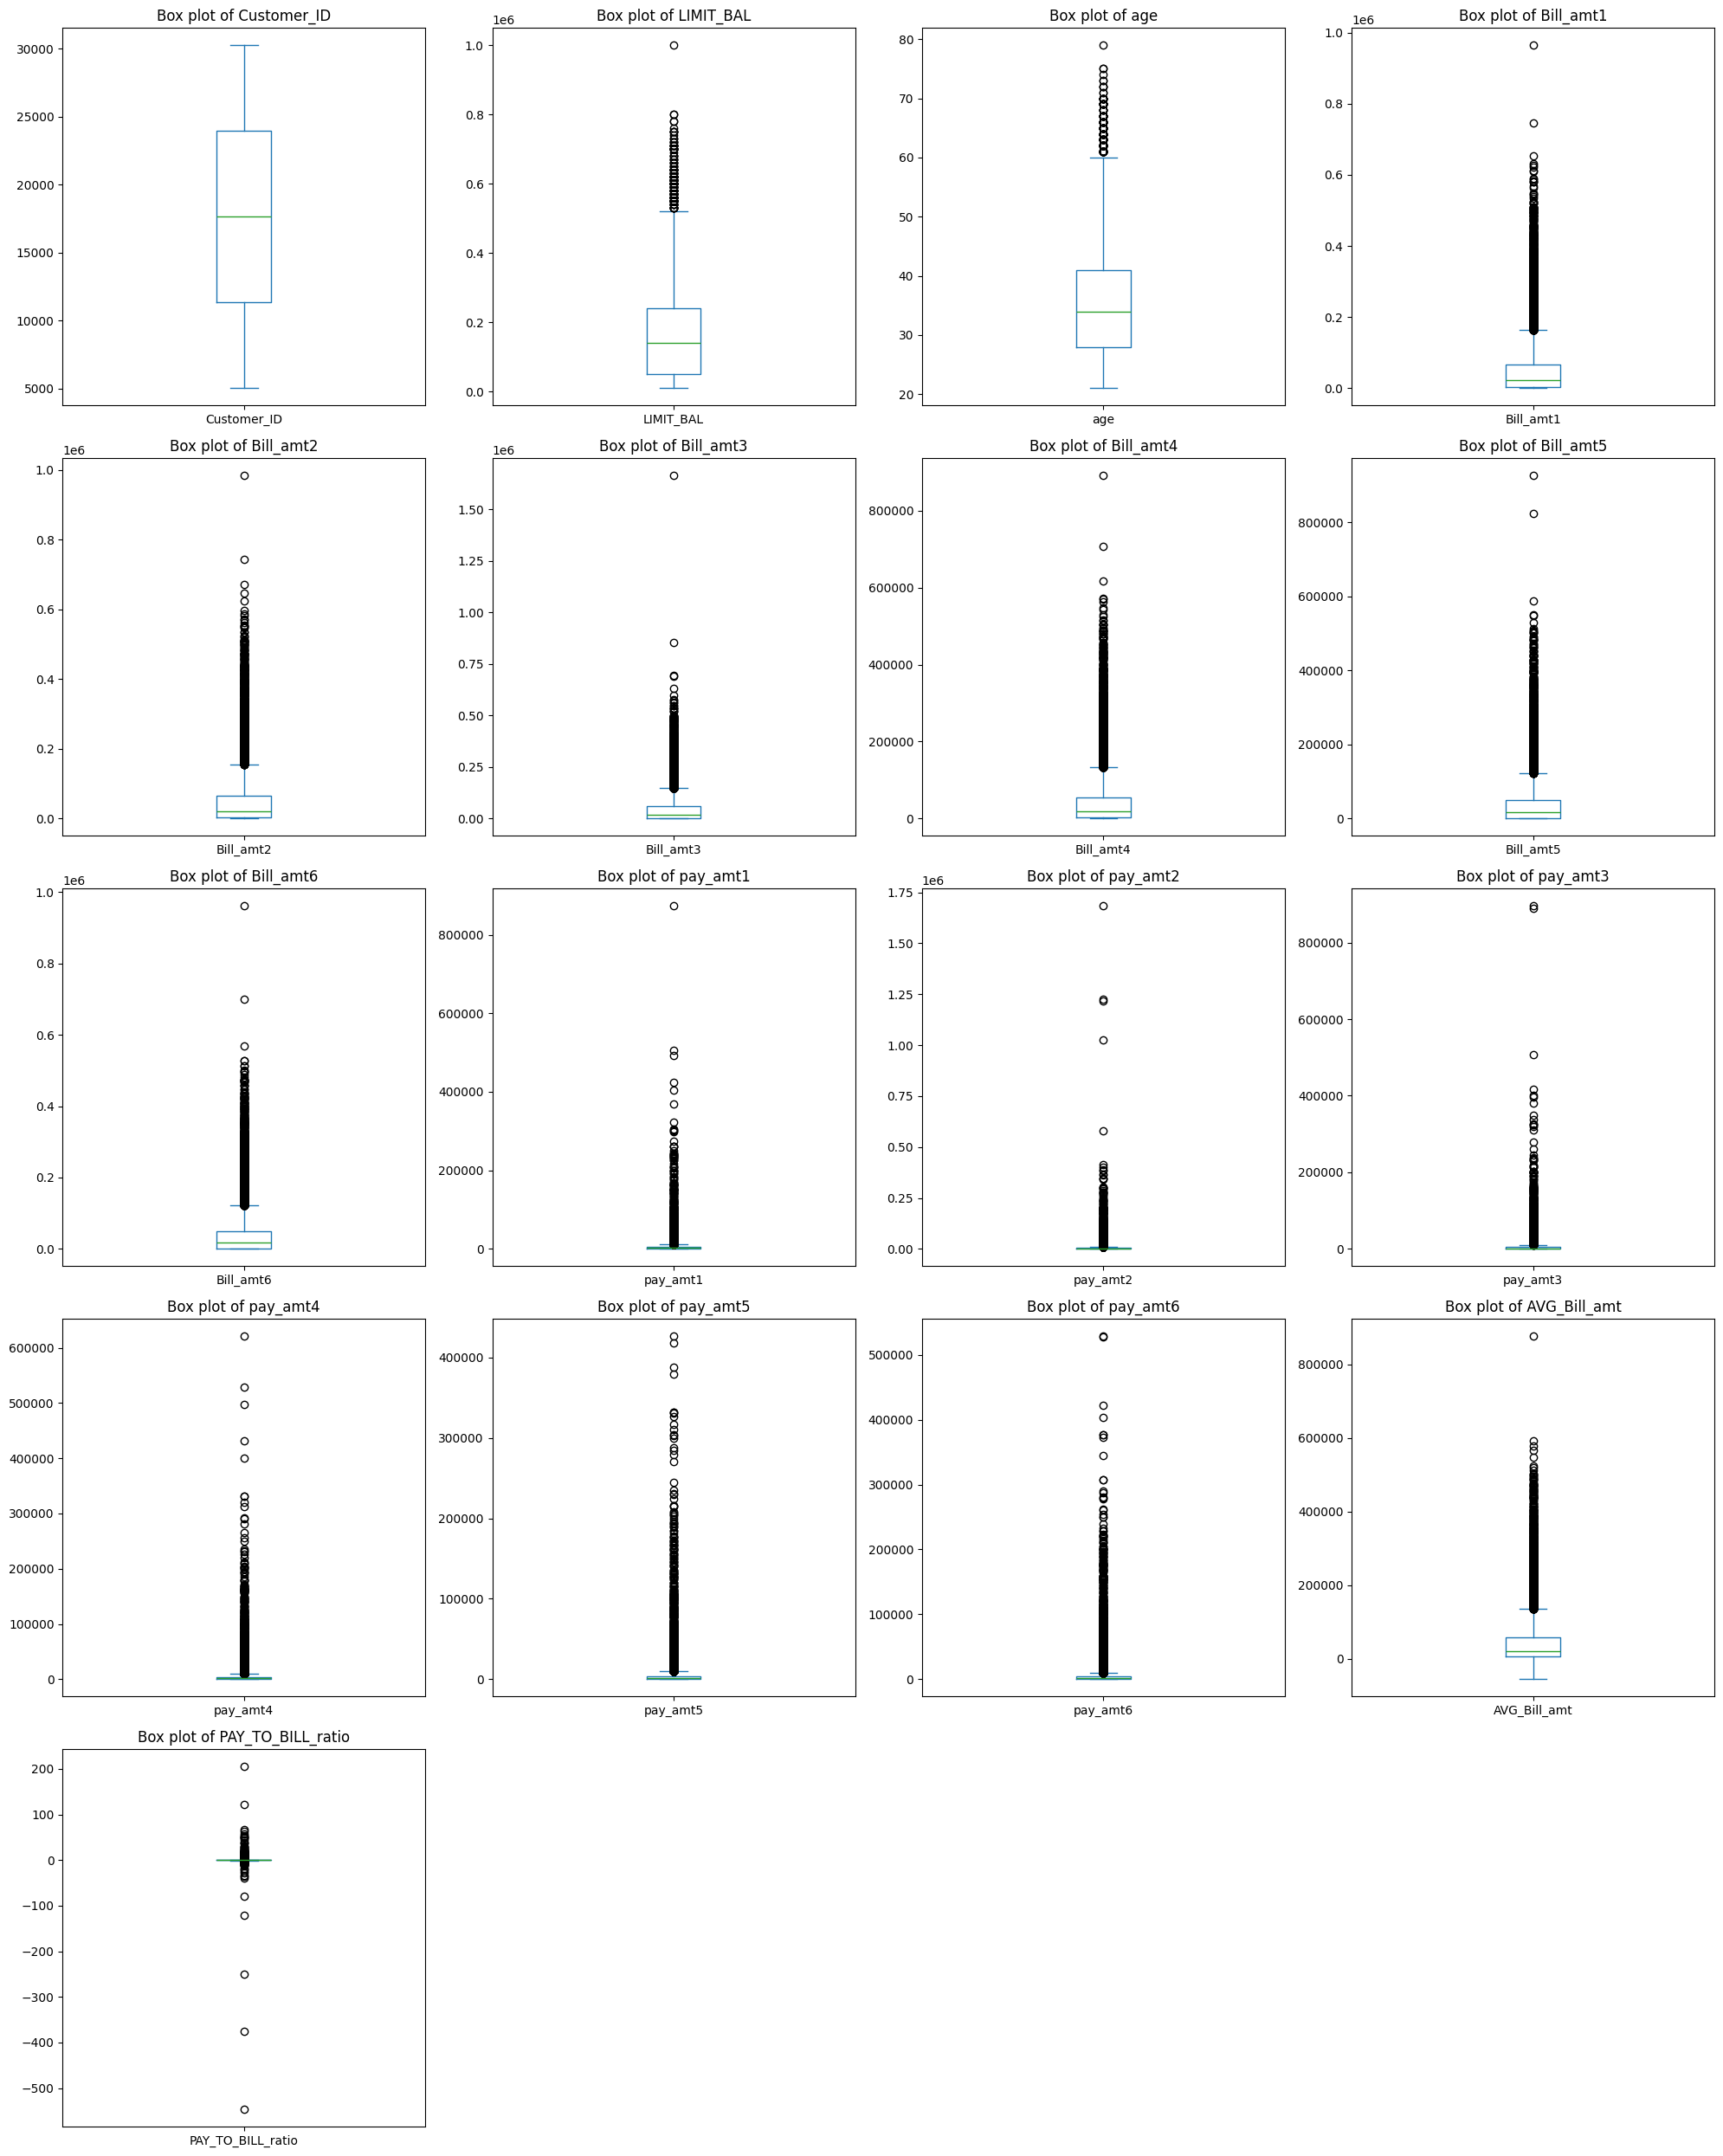

In [21]:
import matplotlib.pyplot as plt

# Select all numeric columns
numeric_cols = train_df.select_dtypes(include=['number']).columns.tolist()

# Set up subplots
num_cols = len(numeric_cols)
cols_per_row = 4  # Adjust as needed
rows = (num_cols + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    train_df[col].plot(kind='box', ax=axes[i])
    axes[i].set_title(f'Box plot of {col}')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Many columns seem to have outliers. However, financial outliers may not always be useless, so we would have major focus on rectifying AVG_Bill_amt and PAY_TO_BILL_ratio columns.

### Checking AVG_Bill_amt Calculation
AVG_Bill_amt should be the average of the six monthly bill amounts (Bill_amt1 to Bill_amt6).

In [22]:
# Calculate average and round to 2 decimals
bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]
train_df['AVG_Bill_amt_check'] = train_df[bill_cols].mean(axis=1).round(2)

# Compare with tolerance (±20)
tolerance = 20
mismatch_avg = (abs(train_df['AVG_Bill_amt_check'] - train_df['AVG_Bill_amt']) > tolerance).sum()
print(f"Rows where AVG_Bill_amt differs by >{tolerance}: {mismatch_avg}")

Rows where AVG_Bill_amt differs by >20: 997


Considering a huge chunk of the dataset value varies greatly from the average calculated manually, we need to ensure that the difference is minimal. For that, we intend to overwrite the column value with the actual calculated average.

In [23]:
# Recalculate and overwrite the columns
bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]
train_df['AVG_Bill_amt'] = train_df[bill_cols].mean(axis=1).round(2)

In [24]:
# Doing the same in validation
bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]
validation_df['AVG_Bill_amt'] = validation_df[bill_cols].mean(axis=1).round(2)

### Checking PAY_TO_BILL_ratio Calculation

In [25]:
pay_cols = [f'pay_amt{i}' for i in range(1, 7)]
train_df['PAY_TO_BILL_ratio_check'] = train_df[pay_cols].sum(axis=1) / train_df[bill_cols].sum(axis=1)

# Compare with the provided column (allowing for small floating point differences)
mismatch_ratio = (abs(train_df['PAY_TO_BILL_ratio_check'].round(2) - train_df['PAY_TO_BILL_ratio']) > 0.0).sum()
print(f"Rows where PAY_TO_BILL_ratio does not match calculation: {mismatch_ratio}")

Rows where PAY_TO_BILL_ratio does not match calculation: 1815


Similar to previous case, we intend to overwrite the column value with the actual calculated value.

In [26]:
pay_cols = [f'pay_amt{i}' for i in range(1, 7)]
bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]

total_payment = train_df[pay_cols].sum(axis=1)
total_bill = train_df[bill_cols].sum(axis=1)

# Handle division by zero and invalid values
train_df['PAY_TO_BILL_ratio'] = np.where(
    total_bill != 0,
    (total_payment / total_bill).round(2),  # Round to 2 decimals
    0
)

In [27]:
#doing the same in validation
total_payment = validation_df[pay_cols].sum(axis=1)
total_bill = validation_df[bill_cols].sum(axis=1)

# Handle division by zero and invalid values
validation_df['PAY_TO_BILL_ratio'] = np.where(
    total_bill != 0,
    (total_payment / total_bill).round(2),  # Round to 2 decimals
    0
)

In [28]:
#Dropping columns created for intermediate calculations
train_df = train_df.drop(['AVG_Bill_amt_check', 'PAY_TO_BILL_ratio_check'], axis=1)

In [29]:
train_df.describe()

,Customer_ID,LIMIT_BAL,age,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
count,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000
mean,17640.000000,168342.060443,35.431022,51170.887938,49092.268745,4.695839e+04,43134.911103,40218.976171,38806.221029,5718.624966,6.047352e+03,5288.910651,4865.960834,4906.766828,5270.499287,44896.942424,57.126134
std,7288.325459,129892.784807,9.152635,73250.806650,70695.367650,6.895687e+04,63846.205694,60389.690737,59182.792531,16806.842125,2.400962e+04,17851.879609,15979.116544,15860.726852,17960.816915,62807.602568,5504.956238
min,5017.000000,10000.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11328.500000,50000.000000,28.000000,3601.340000,3017.155000,2.753275e+03,2319.615000,1770.625000,1241.710000,999.985000,9.219100e+02,399.990000,300.150000,262.365000,130.070000,4897.425000,0.040000
50%,17640.000000,140000.000000,34.000000,22436.740000,21245.880000,2.008554e+04,19027.840000,18069.760000,17102.580000,2145.020000,2.026830e+03,1844.300000,1500.100000,1513.790000,1500.040000,21112.810000,0.100000
75%,23951.500000,240000.000000,41.000000,67373.410000,64151.875000,6.022971e+04,54391.160000,50289.525000,49245.195000,5031.150000,5.000190e+03,4600.640000,4014.990000,4099.890000,4018.780000,57142.730000,0.630000
max,30263.000000,1000000.000000,79.000000,964511.160000,983931.050000,1.664089e+06,891585.580000,927172.770000,961663.620000,873551.980000,1.684259e+06,896040.150000,621000.080000,426529.180000,528666.150000,877314.080000,852634.320000


In [30]:
validation_df.describe()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
count,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,...,5016.000000,5016.000000,5016.000000,5.016000e+03,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000
mean,2508.500000,1.559410,0.606659,1.827751,168977.272727,35.379785,-0.031300,-0.161683,-0.188198,-0.235048,...,41244.782709,39805.868369,5356.196780,6.321958e+03,5420.142849,5150.979306,4926.404159,5148.384402,46087.496934,6.207396
std,1448.138806,0.516969,0.488540,0.740668,129478.787500,9.206542,1.116011,1.178731,1.172155,1.129667,...,62255.394325,60698.632561,13660.489329,2.920905e+04,17011.204561,17376.949234,17085.022267,16879.411346,65209.859696,178.692116
min,1.000000,1.000000,0.000000,1.000000,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1254.750000,1.000000,0.000000,1.000000,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1755.395000,1205.210000,1000.047500,9.899050e+02,403.265000,278.172500,299.310000,156.382500,4921.275000,0.040000
50%,2508.500000,2.000000,1.000000,2.000000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,17953.255000,17054.315000,2093.655000,2.000410e+03,1845.425000,1500.120000,1500.155000,1453.210000,20933.005000,0.110000
75%,3762.250000,2.000000,1.000000,2.000000,240000.000000,41.250000,0.000000,0.000000,0.000000,0.000000,...,50175.052500,49070.565000,5029.505000,5.000323e+03,4883.887500,4282.550000,4097.725000,4000.095000,56572.967500,0.610000
max,5016.000000,3.000000,1.000000,4.000000,800000.000000,75.000000,8.000000,7.000000,7.000000,7.000000,...,547880.830000,513798.830000,323014.110000,1.684259e+06,371717.910000,432129.910000,426529.180000,260000.100000,548854.640000,9525.900000


### Dealing With Outliers in PAT_TO_BILL_ratio

<Axes: >

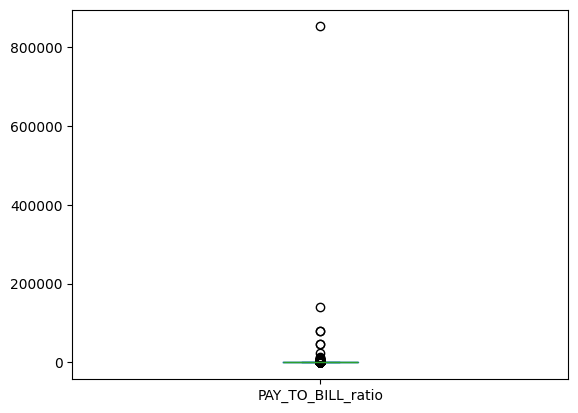

In [31]:
train_df['PAY_TO_BILL_ratio'].plot(kind='box') #box plot

In [32]:
percentile_95 = train_df['PAY_TO_BILL_ratio'].quantile(0.95).round(2)
print(percentile_95)
percentile_99 = train_df['PAY_TO_BILL_ratio'].quantile(0.99).round(2)
print(percentile_99)

1.21
3.9


Such low percentiles compared to the average suggest very high outliers, which need to be eliminated. We can clip the PAY_TO_BILL_ratio column to restrict it to a much lower value, say percentile_99.

In [33]:
train_df['PAY_TO_BILL_ratio_clipped'] = train_df['PAY_TO_BILL_ratio'].clip(upper=percentile_99)

In [34]:
#Dropping the column used for intermediate calculation
train_df = train_df.drop(['PAY_TO_BILL_ratio_clipped'], axis=1)

In [35]:
validation_df['PAY_TO_BILL_ratio_clipped'] = validation_df['PAY_TO_BILL_ratio'].clip(upper=percentile_99)
validation_df = validation_df.drop(['PAY_TO_BILL_ratio_clipped'], axis=1)

In [36]:
train_df.describe()

,Customer_ID,LIMIT_BAL,age,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
count,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000
mean,17640.000000,168342.060443,35.431022,51170.887938,49092.268745,4.695839e+04,43134.911103,40218.976171,38806.221029,5718.624966,6.047352e+03,5288.910651,4865.960834,4906.766828,5270.499287,44896.942424,57.126134
std,7288.325459,129892.784807,9.152635,73250.806650,70695.367650,6.895687e+04,63846.205694,60389.690737,59182.792531,16806.842125,2.400962e+04,17851.879609,15979.116544,15860.726852,17960.816915,62807.602568,5504.956238
min,5017.000000,10000.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11328.500000,50000.000000,28.000000,3601.340000,3017.155000,2.753275e+03,2319.615000,1770.625000,1241.710000,999.985000,9.219100e+02,399.990000,300.150000,262.365000,130.070000,4897.425000,0.040000
50%,17640.000000,140000.000000,34.000000,22436.740000,21245.880000,2.008554e+04,19027.840000,18069.760000,17102.580000,2145.020000,2.026830e+03,1844.300000,1500.100000,1513.790000,1500.040000,21112.810000,0.100000
75%,23951.500000,240000.000000,41.000000,67373.410000,64151.875000,6.022971e+04,54391.160000,50289.525000,49245.195000,5031.150000,5.000190e+03,4600.640000,4014.990000,4099.890000,4018.780000,57142.730000,0.630000
max,30263.000000,1000000.000000,79.000000,964511.160000,983931.050000,1.664089e+06,891585.580000,927172.770000,961663.620000,873551.980000,1.684259e+06,896040.150000,621000.080000,426529.180000,528666.150000,877314.080000,852634.320000


In [37]:
validation_df.describe()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
count,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,...,5016.000000,5016.000000,5016.000000,5.016000e+03,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000
mean,2508.500000,1.559410,0.606659,1.827751,168977.272727,35.379785,-0.031300,-0.161683,-0.188198,-0.235048,...,41244.782709,39805.868369,5356.196780,6.321958e+03,5420.142849,5150.979306,4926.404159,5148.384402,46087.496934,6.207396
std,1448.138806,0.516969,0.488540,0.740668,129478.787500,9.206542,1.116011,1.178731,1.172155,1.129667,...,62255.394325,60698.632561,13660.489329,2.920905e+04,17011.204561,17376.949234,17085.022267,16879.411346,65209.859696,178.692116
min,1.000000,1.000000,0.000000,1.000000,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1254.750000,1.000000,0.000000,1.000000,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1755.395000,1205.210000,1000.047500,9.899050e+02,403.265000,278.172500,299.310000,156.382500,4921.275000,0.040000
50%,2508.500000,2.000000,1.000000,2.000000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,17953.255000,17054.315000,2093.655000,2.000410e+03,1845.425000,1500.120000,1500.155000,1453.210000,20933.005000,0.110000
75%,3762.250000,2.000000,1.000000,2.000000,240000.000000,41.250000,0.000000,0.000000,0.000000,0.000000,...,50175.052500,49070.565000,5029.505000,5.000323e+03,4883.887500,4282.550000,4097.725000,4000.095000,56572.967500,0.610000
max,5016.000000,3.000000,1.000000,4.000000,800000.000000,75.000000,8.000000,7.000000,7.000000,7.000000,...,547880.830000,513798.830000,323014.110000,1.684259e+06,371717.910000,432129.910000,426529.180000,260000.100000,548854.640000,9525.900000


In [38]:
total_bill = train_df[bill_cols].sum(axis=1)
zero_bill_entries = train_df[total_bill == 0]
zero_bill_entries

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
368,5385,2,1,2,10000,23.0,1,-2,-2,-2,...,0.0,0.23,0.00,0.13,0.00,0.03,999.85,0.0,0.0,1
1176,6193,1,1,2,320000,36.0,-2,-2,-2,-2,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0
1901,6918,1,0,2,130000,42.0,1,-2,-2,-2,...,0.0,0.00,0.01,0.00,0.00,0.01,999.84,0.0,0.0,1
2372,7389,2,1,1,500000,51.0,1,-2,-2,-2,...,0.0,0.00,0.19,0.33,0.15,0.17,0.00,0.0,0.0,0
2435,7452,1,0,1,240000,39.0,1,-2,-2,-2,...,0.0,0.26,0.01,0.00,0.00,0.09,0.11,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24774,29791,1,1,2,240000,36.0,1,-2,-2,-2,...,0.0,0.14,0.00,0.00,0.18,0.00,0.00,0.0,0.0,1
24813,29830,1,1,1,220000,41.0,1,-2,-2,-2,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1
24900,29917,2,1,1,140000,37.0,1,-2,-2,-2,...,0.0,0.00,0.00,0.00,0.02,0.00,0.17,0.0,0.0,0
25104,30121,2,1,1,320000,34.0,-2,-2,-2,-2,...,0.0,0.00,4.44,0.08,0.00,0.07,0.06,0.0,0.0,0


# Correlation Heatmap for the Dataset

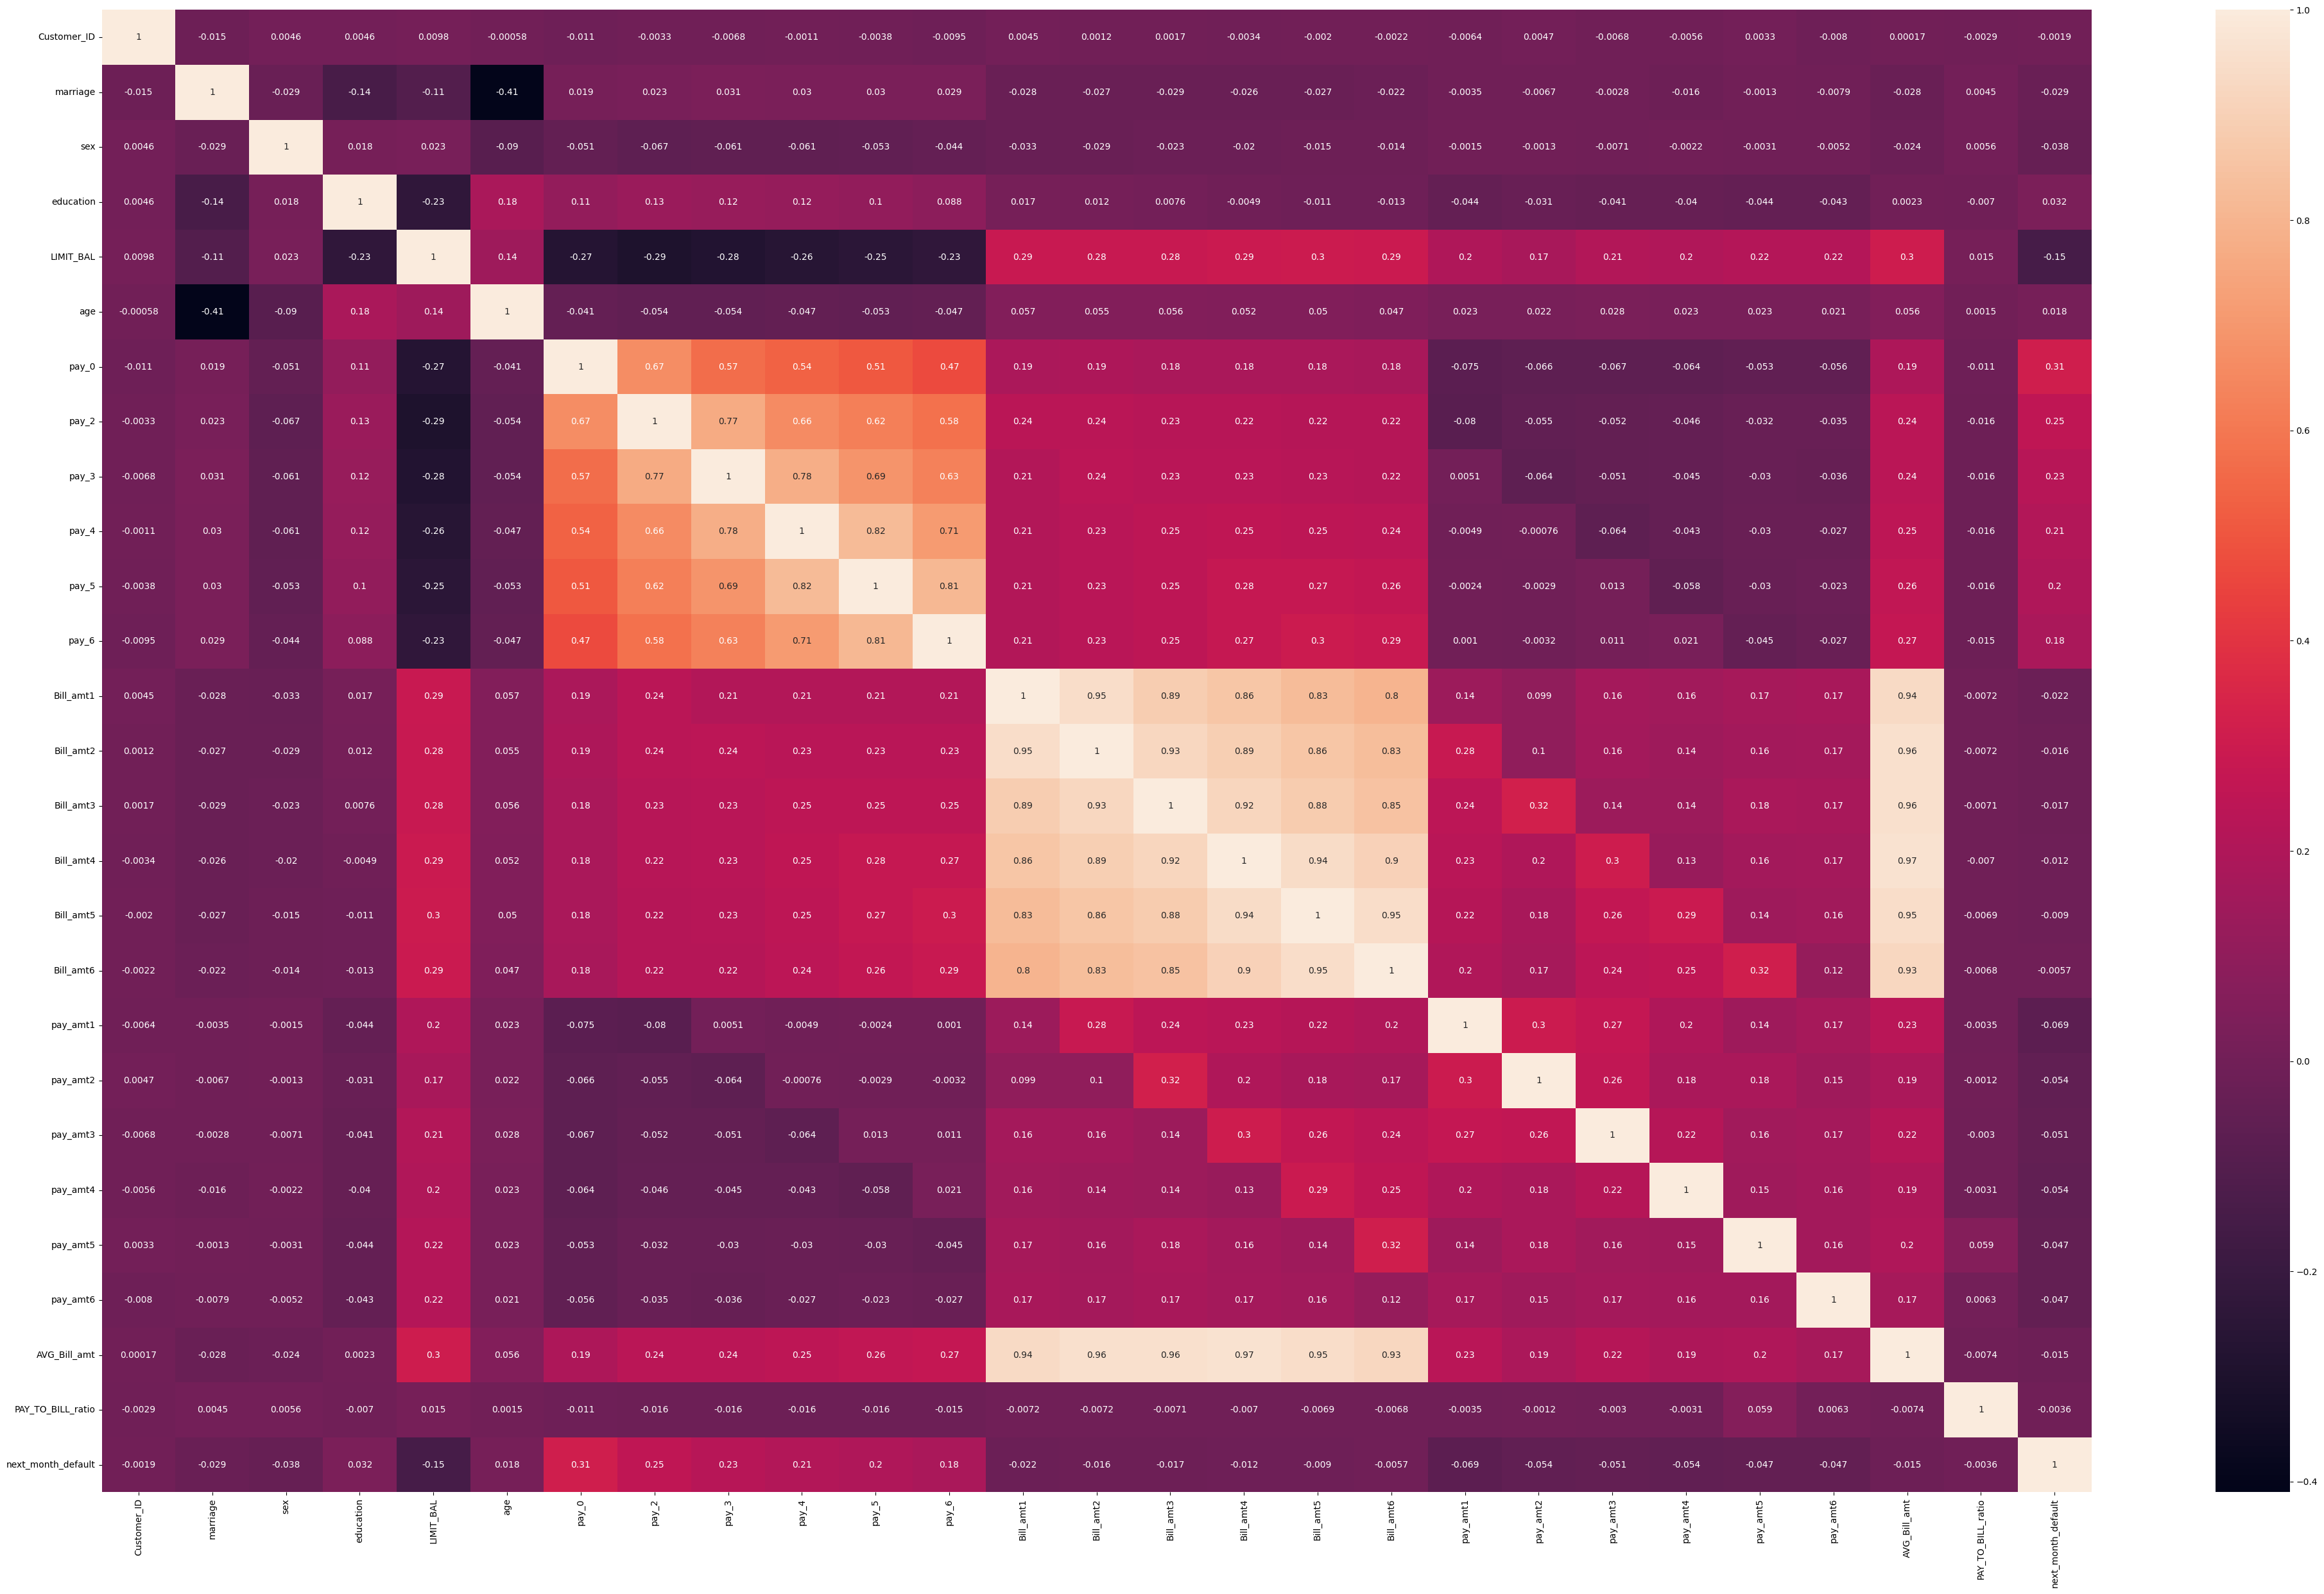

In [39]:
#sns.heatmap(train_df.corr(), cmap='YlOrBr')
#plt.title('Correlation heatmap for the entire dataset')
#plt.show()

# Seeing the Correlation between Features and targets
plt.figure(figsize=(50,30))
sns.heatmap(train_df.corr(), annot=True)
plt.show()

Clearly, column Customer_ID can be dropped.

In [40]:
train_df.drop(columns=['Customer_ID'], inplace=True)

The next_month_default variable shows only weak correlations with the other numeric features. This suggests that no single variable here is a strong standalone predictor of default, and that combinations or more complex features are needed for effective risk modeling.

In [41]:
df = train_df.copy()
# Convert default column to numeric for further analysis
df['next_month_default'] = df['next_month_default'].astype(int)

# Convert demographic columns to strings for further analysis
demographic_cols = ['sex', 'marriage', 'education']
for col in demographic_cols:
    df[col] = df[col].astype(str)
plt.style.use('default')
fig_count = 0

### Analysing High Correlation between columns Bill_amt1 - Bill_amt6

It is also observed that Bill_amt_1 - Bill_amt_6 seem to have a high correlation. Plotting the correlation matrix for these columns:

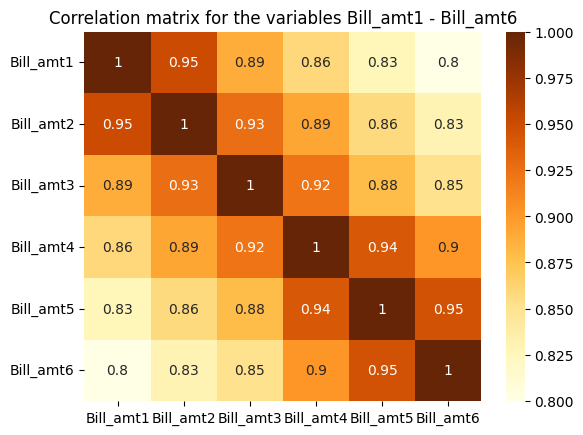

In [42]:
sns.heatmap(train_df.loc[:, 'Bill_amt1':'Bill_amt6'].corr(), annot=True, cmap='YlOrBr')
plt.title('Correlation matrix for the variables Bill_amt1 - Bill_amt6')
plt.show()

The variables are highly positively correlated (all correlation coefficients > 0.8). This shows that any of these variables contains most of the information present in the others. Therefore, it makes sense to aggregate these variables into one. AVG_Bill_amt is already an average of these columns, which is also highly correlated to these columns individually. Hence, these 6 columns can be dropped. However, we will retain them for sometime to do relevant feature engineering.

In [43]:
train_df.describe()

,LIMIT_BAL,age,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
count,25247.000000,25247.000000,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000
mean,168342.060443,35.431022,51170.887938,49092.268745,4.695839e+04,43134.911103,40218.976171,38806.221029,5718.624966,6.047352e+03,5288.910651,4865.960834,4906.766828,5270.499287,44896.942424,57.126134
std,129892.784807,9.152635,73250.806650,70695.367650,6.895687e+04,63846.205694,60389.690737,59182.792531,16806.842125,2.400962e+04,17851.879609,15979.116544,15860.726852,17960.816915,62807.602568,5504.956238
min,10000.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3601.340000,3017.155000,2.753275e+03,2319.615000,1770.625000,1241.710000,999.985000,9.219100e+02,399.990000,300.150000,262.365000,130.070000,4897.425000,0.040000
50%,140000.000000,34.000000,22436.740000,21245.880000,2.008554e+04,19027.840000,18069.760000,17102.580000,2145.020000,2.026830e+03,1844.300000,1500.100000,1513.790000,1500.040000,21112.810000,0.100000
75%,240000.000000,41.000000,67373.410000,64151.875000,6.022971e+04,54391.160000,50289.525000,49245.195000,5031.150000,5.000190e+03,4600.640000,4014.990000,4099.890000,4018.780000,57142.730000,0.630000
max,1000000.000000,79.000000,964511.160000,983931.050000,1.664089e+06,891585.580000,927172.770000,961663.620000,873551.980000,1.684259e+06,896040.150000,621000.080000,426529.180000,528666.150000,877314.080000,852634.320000


### Analysing High Correlation between columns pay_0 - pay_6

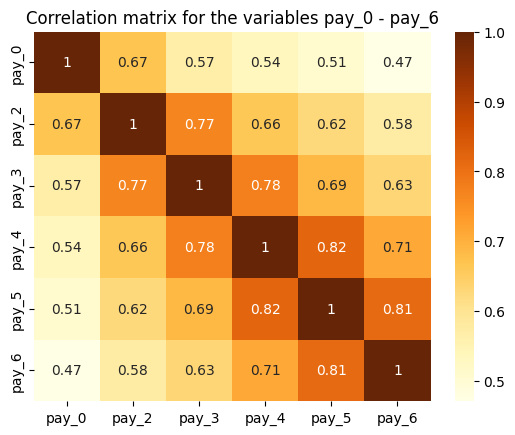

In [44]:
sns.heatmap(train_df.loc[:, 'pay_0':'pay_6'].corr(), annot=True, cmap='YlOrBr')
plt.title('Correlation matrix for the variables pay_0 - pay_6')
plt.show()

The payment amount features (pay_amt1 through pay_amt6) show moderate positive correlations with each other (orange squares). This is expected, as customers who pay more in one month often pay more in other months as well.

It is very clear that the payment status in one month tends to be similar to adjacent months, which is expected in sequential financial data.

# Numeric variable relationship with next_month_default

### Analysis With KDE Plots

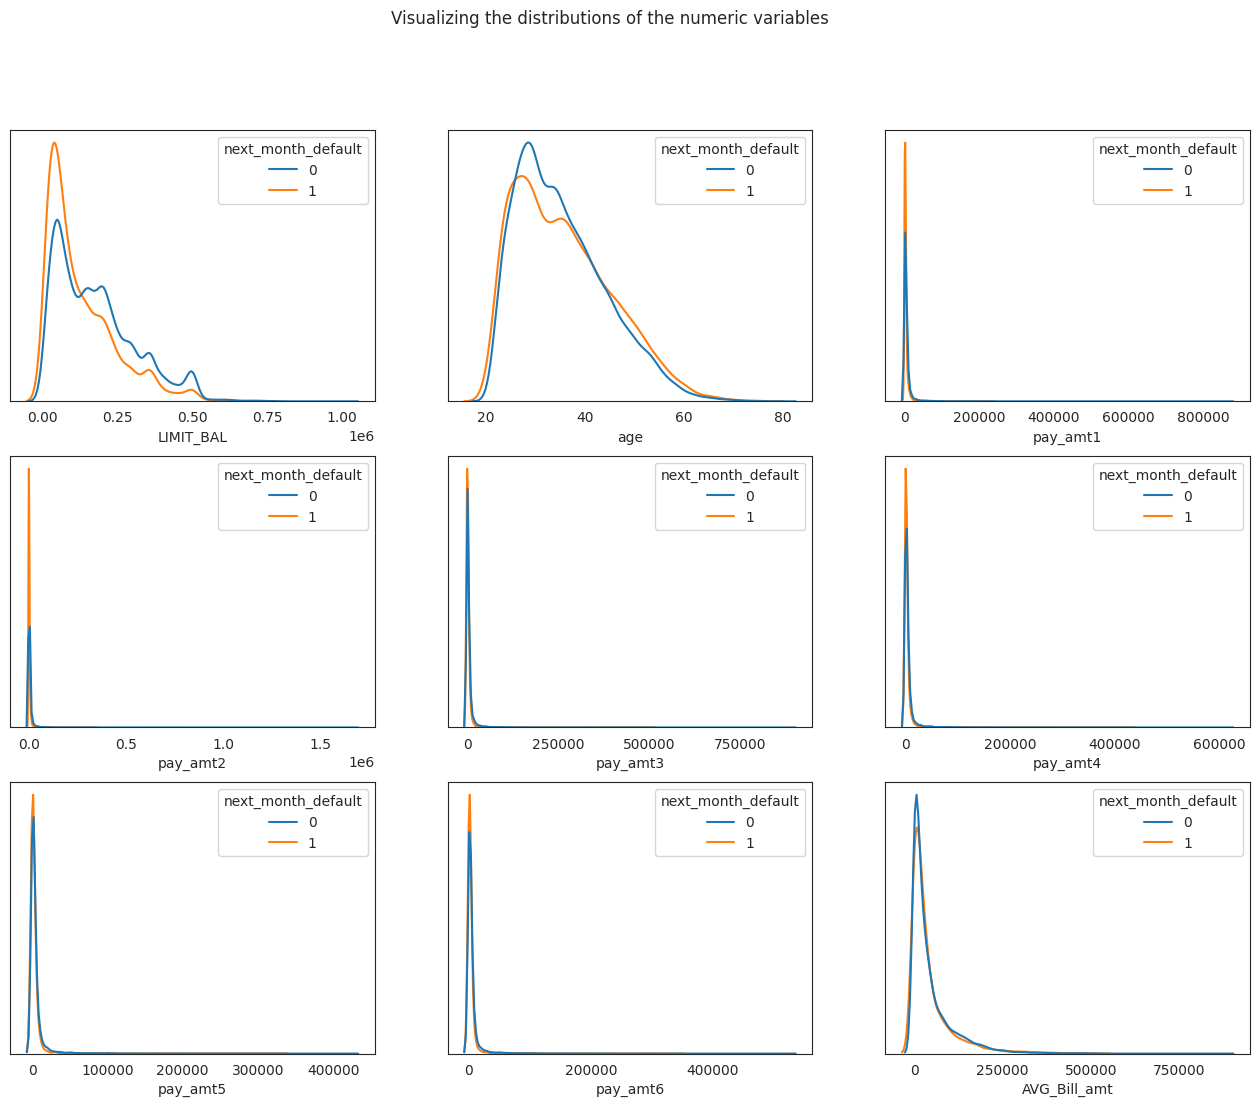

In [45]:
sns.set_style('white')

num_cols = ['LIMIT_BAL', 'age', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt']
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
for col, ax in zip(num_cols, axs.ravel()):
    sns.kdeplot(data=train_df, hue='next_month_default', x=col, ax=ax, common_norm=False)
    ax.set_yticklabels('')
    ax.set_yticks([])
    ax.locator_params(axis='x', nbins=5)
    ax.set_ylabel('')

fig.suptitle('Visualizing the distributions of the numeric variables')

plt.show()

We see that the distribution of LIMIT_BAL and AVG_Bill_amt for clients that defaulted and that did not default is quite similar, while those that defaulted were on average slightly younger in age.
The distributions for the other variables (pay_amt1 - pay_amt6) aren't as informative due to the distributions being extremely positively skewed.

### Credit Limit Analysis

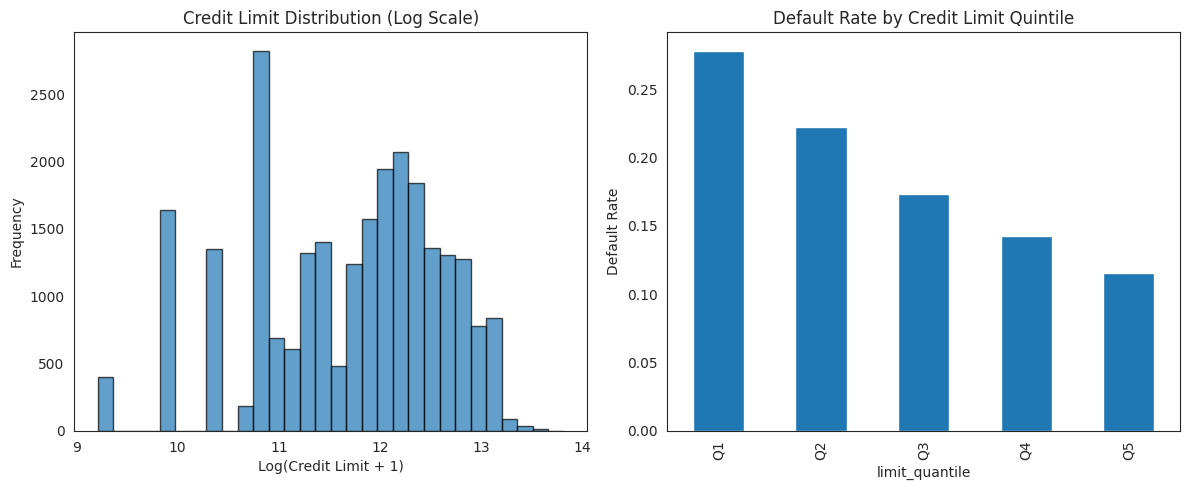

In [46]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(np.log1p(df['LIMIT_BAL']), bins=30, alpha=0.7, edgecolor='black')
plt.title('Credit Limit Distribution (Log Scale)')
plt.xlabel('Log(Credit Limit + 1)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df['limit_quantile'] = pd.qcut(df['LIMIT_BAL'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5']).astype(str)
limit_default = df.groupby('limit_quantile')['next_month_default'].mean()
limit_default.plot(kind='bar')
plt.title('Default Rate by Credit Limit Quintile')
plt.ylabel('Default Rate')

plt.tight_layout()
plt.show()

There is a clear negative relationship: as the credit limit increases (from Q1 to Q5), the default rate decreases.

*   Q1 (lowest credit limits) has the highest default rate (over 0.27, or 27%).
*   Q5 (highest credit limits) has the lowest default rate (around 0.13, or 13%).

This suggests that customers with lower credit limits are more likely to default on their payments, while those with higher credit limits are less likely to default.

### Payment Status Analysis

<ipython-input-47-92afd9a76e77>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pay_default = df.groupby(col)['next_month_default'].mean()
<ipython-input-47-92afd9a76e77>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pay_default = df.groupby(col)['next_month_default'].mean()
<ipython-input-47-92afd9a76e77>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pay_default = df.groupby(col)['next_month_default'].mean()
<ipy

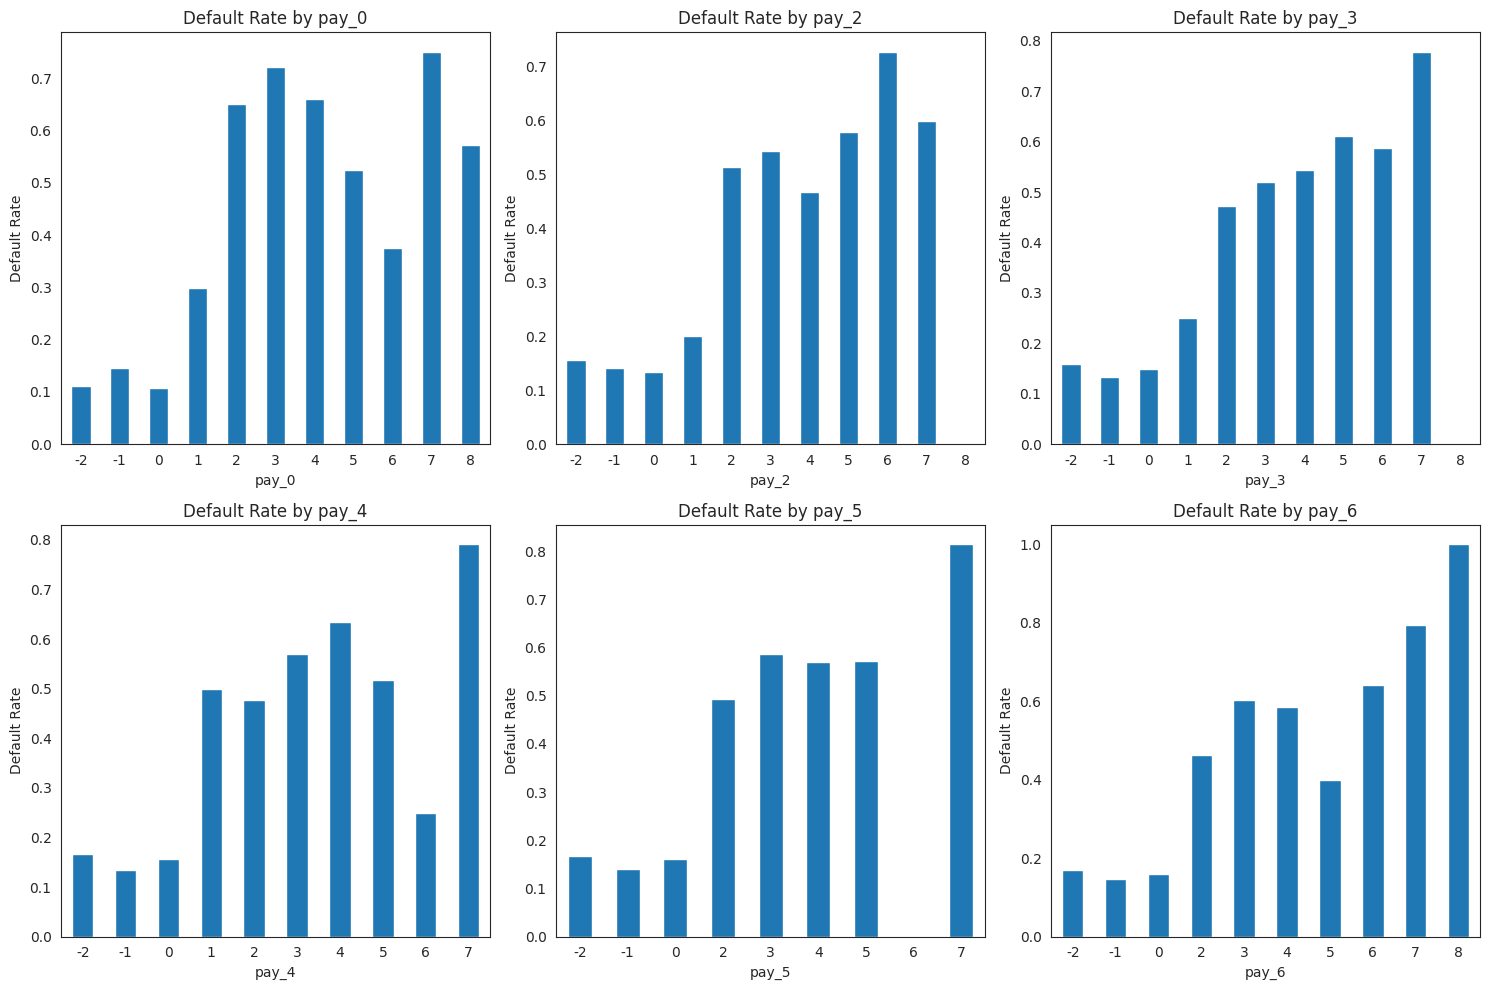

In [47]:
pay_status_cols = [f'pay_{i}' for i in [0, 2, 3, 4, 5, 6]]

plt.figure(figsize=(15, 10))

for i, col in enumerate(pay_status_cols, 1):
  plt.subplot(2, 3, i)
  pay_default = df.groupby(col)['next_month_default'].mean()
  pay_default.plot(kind='bar')
  plt.title(f'Default Rate by {col}')
  plt.ylabel('Default Rate')
  plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

* **Default Rate Increases with Payment Delay**:
For all six months shown (pay_0 to pay_6), the default rate is lowest for those who made timely or early payments or partial payments, and rises sharply as the payments get missed regularly with longer delays.

* **High Risk with Greater Delinquency**:
When the customer is three or more months behind, the default rate often exceeds 50% and can reach as high as 80–90% for the highest delay values.

* **Consistent Pattern Across Months**:
This trend is consistent across all the months visualized, suggesting that recent and historical payment behavior are both **strong predictors of default risk**.
Customers with recent or repeated serious delinquencies are at extremely high risk of default.

### Bill and Payment Amount Analysis

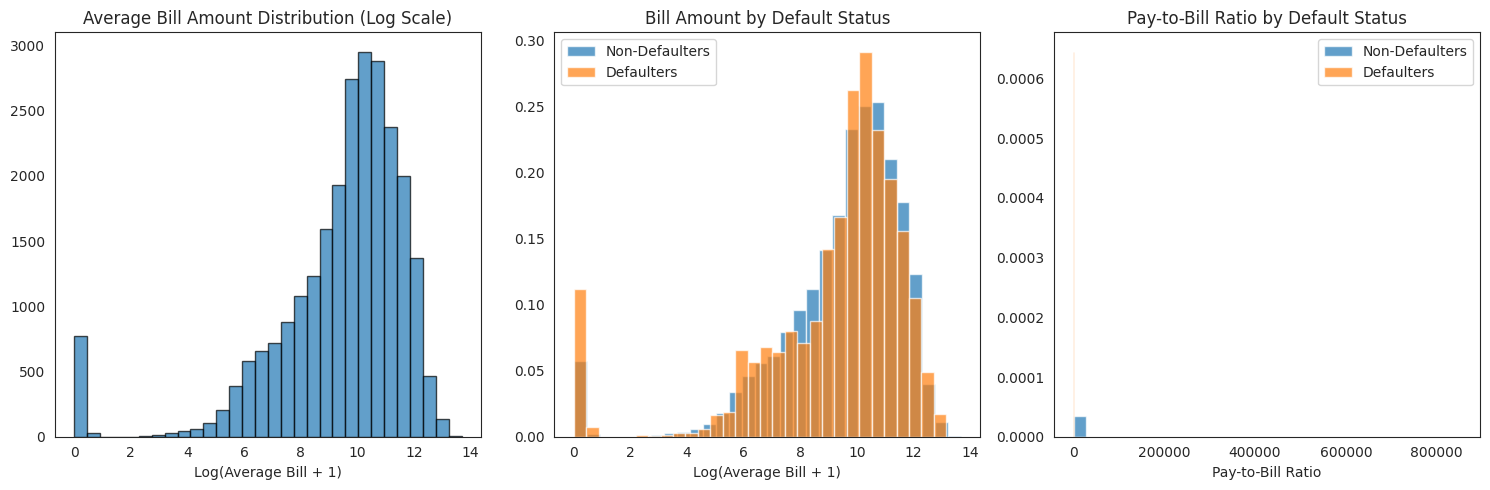

In [48]:
plt.figure(figsize=(15, 5))

#distribution of the log-transformed average bill amount across all customers.
plt.subplot(1, 3, 1)
plt.hist(np.log1p(df['AVG_Bill_amt']), bins=30, alpha=0.7, edgecolor='black')
plt.title('Average Bill Amount Distribution (Log Scale)')
plt.xlabel('Log(Average Bill + 1)')

plt.subplot(1, 3, 2)

defaulters = df[df['next_month_default'] == 1]['AVG_Bill_amt']
non_defaulters = df[df['next_month_default'] == 0]['AVG_Bill_amt']

#distribution of the log-transformed average bill amount, split by default status (Non-Defaulters vs. Defaulters).
plt.hist(np.log1p(non_defaulters), bins=30, alpha=0.7, label='Non-Defaulters', density=True)
plt.hist(np.log1p(defaulters), bins=30, alpha=0.7, label='Defaulters', density=True)
plt.title('Bill Amount by Default Status')
plt.xlabel('Log(Average Bill + 1)')
plt.legend()

plt.subplot(1, 3, 3)

defaulter_ratios = df[df['next_month_default'] == 1]['PAY_TO_BILL_ratio']
non_defaulter_ratios = df[df['next_month_default'] == 0]['PAY_TO_BILL_ratio']

plt.hist(non_defaulter_ratios, bins=30, alpha=0.7, label='Non-Defaulters', density=True)
plt.hist(defaulter_ratios, bins=30, alpha=0.7, label='Defaulters', density=True)
plt.title('Pay-to-Bill Ratio by Default Status')
plt.xlabel('Pay-to-Bill Ratio')
plt.legend()

plt.tight_layout()
plt.show()


### Observations:

#### Bill Amount by Default Status

Both defaulters and non-defaulters have similar overall distributions, with peaks at similar bill amounts.

However, defaulters (orange) have a slightly higher density at lower bill amounts compared to non-defaulters (blue), especially at the leftmost spike.

This suggests that defaulters are somewhat more likely to have lower average bill amounts than non-defaulters, but there is **significant overlap** between the two groups.


---



#### Pay-to-Bill Ratio by Default Status

There is no clear separation between defaulters and non-defaulters in this plot because most customers pay little relative to their bill, suggesting that pay-to-bill ratio alone may not strongly distinguish default risk in this dataset, or that the feature may need to be capped or transformed for better interpretability.

# Categorial Variable Relationship With next_month_default

### Plotting Defaulters v/s Non-Defaulters Statistics

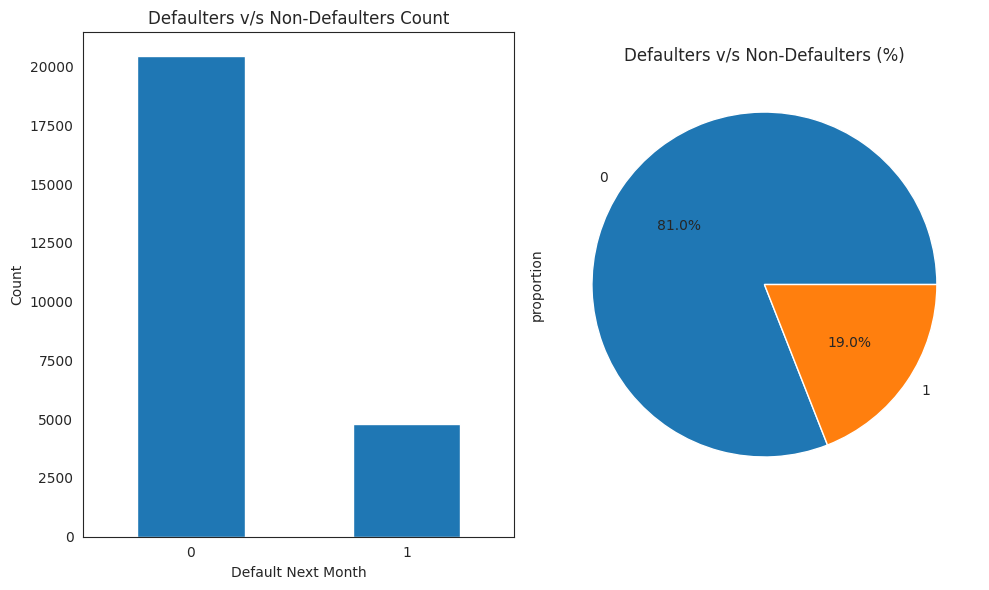

In [49]:
fig_count += 1
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
df['next_month_default'].value_counts().plot(kind='bar')
plt.title('Defaulters v/s Non-Defaulters Count')
plt.xlabel('Default Next Month')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['next_month_default'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Defaulters v/s Non-Defaulters (%)')

plt.tight_layout()
plt.show()


**Class Imbalance:**

* 81% of customers did not default (label 0).

* 19% of customers did default (label 1).

The dataset is imbalanced, with significantly more non-defaulters than defaulters. This can affect model performance, thus we need to use appropriate technique.

### Demographic Analysis

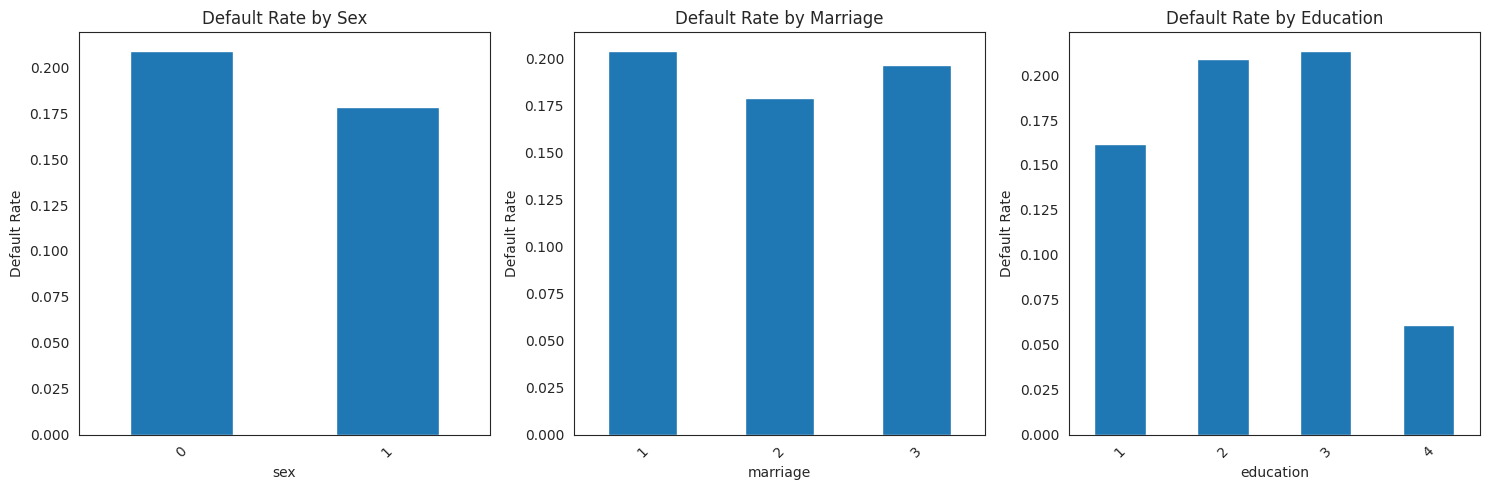

In [50]:
fig_count += 1
plt.figure(figsize=(15, 5))

for i, col in enumerate(demographic_cols, 1):
    if col in df.columns:
        plt.subplot(1, 3, i)
        if 'next_month_default' in df.columns:
            default_by_cat = df.groupby(col)['next_month_default'].agg(['count', 'mean'])
            default_by_cat['mean'].plot(kind='bar')
            plt.title(f'Default Rate by {col.title()}')
            plt.ylabel('Default Rate')
            plt.xticks(rotation=45)
        else:
            df[col].value_counts().plot(kind='bar')
            plt.title(f'Distribution of {col.title()}')
            plt.ylabel('Count')

plt.tight_layout()
plt.show()

**Sex**: There is a clear difference in default rates between the two sexes, women (0) being consistently higher.

**Marriage**: Marital status impacts default rates, with married individuals (1) at greater risk.

**Education**: Education level shows a non-linear relationship with default rates, with high school and university graduates at significantly higher risk.

### Analysis By Age

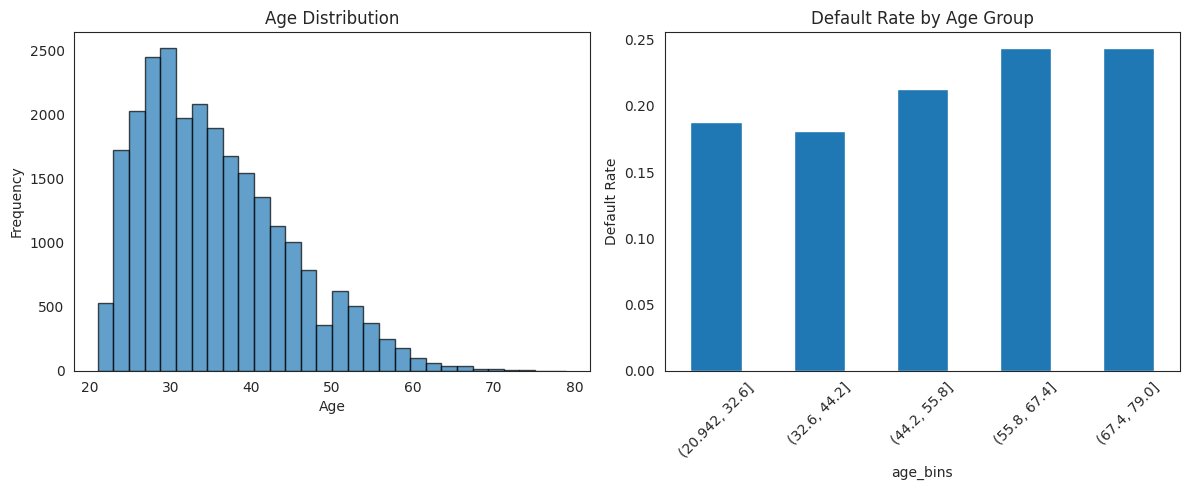

In [51]:
fig_count += 1
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['age'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)

# Age bins and default rate
df['age_bins'] = pd.cut(df['age'], bins=5).astype(str)  # Convert intervals to strings
age_default = df.groupby('age_bins')['next_month_default'].mean()
age_default.plot(kind='bar')
plt.title('Default Rate by Age Group')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Younger individuals (20s to early 30s) are both more numerous and less likely to default.

Older individuals (mid-50s and above), though fewer in number, have a substantially higher default rate.

The risk of default appears to increase with age, especially after age 44.

### Using Stacked Columns

<ipython-input-52-2a64be988afb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train_df.groupby([col, 'next_month_default']).size().unstack(fill_value=0)


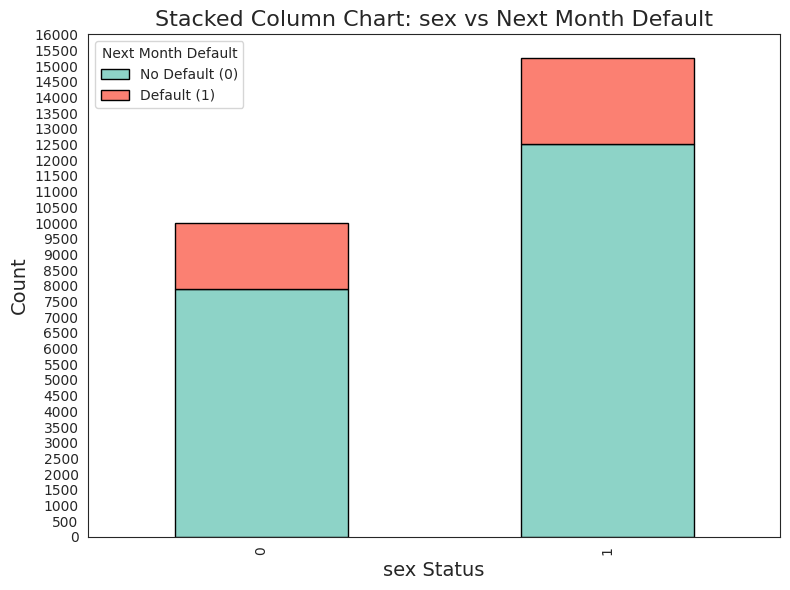

<ipython-input-52-2a64be988afb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train_df.groupby([col, 'next_month_default']).size().unstack(fill_value=0)


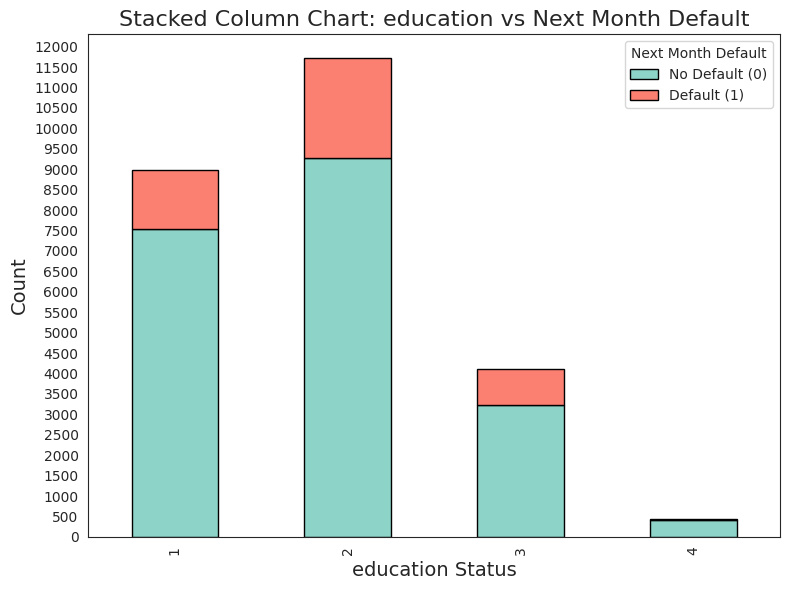

<ipython-input-52-2a64be988afb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train_df.groupby([col, 'next_month_default']).size().unstack(fill_value=0)


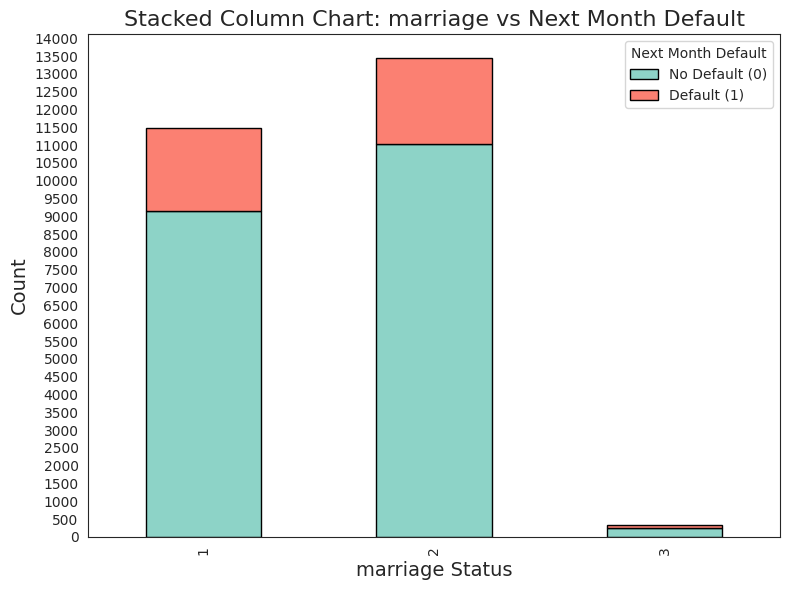

<ipython-input-52-2a64be988afb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train_df.groupby([col, 'next_month_default']).size().unstack(fill_value=0)


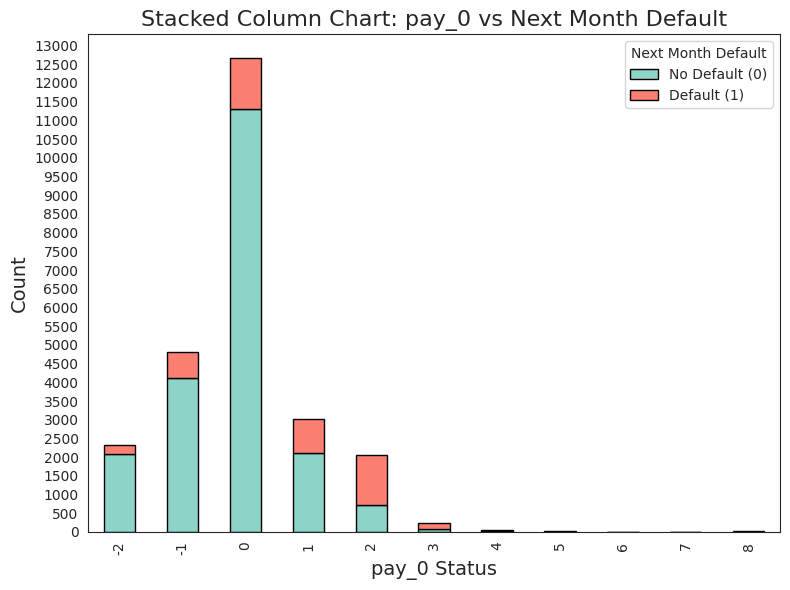

<ipython-input-52-2a64be988afb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train_df.groupby([col, 'next_month_default']).size().unstack(fill_value=0)


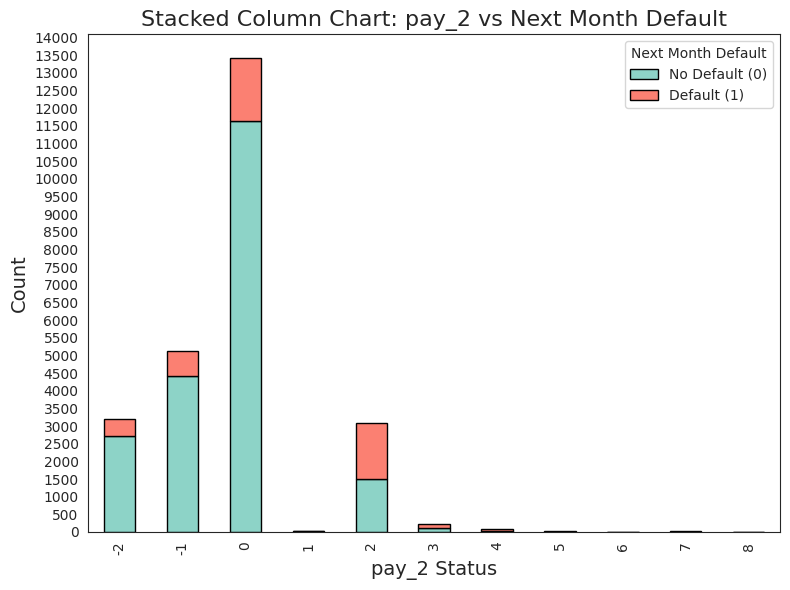

<ipython-input-52-2a64be988afb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train_df.groupby([col, 'next_month_default']).size().unstack(fill_value=0)


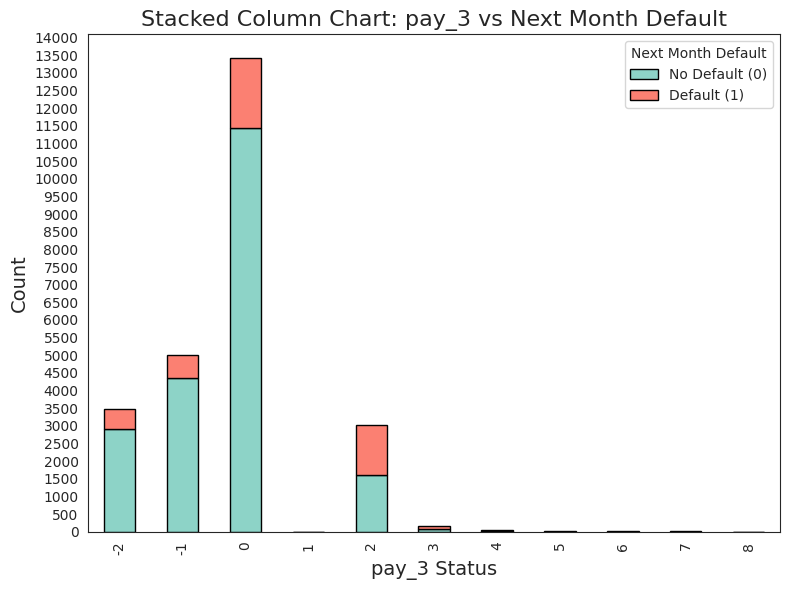

<ipython-input-52-2a64be988afb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train_df.groupby([col, 'next_month_default']).size().unstack(fill_value=0)


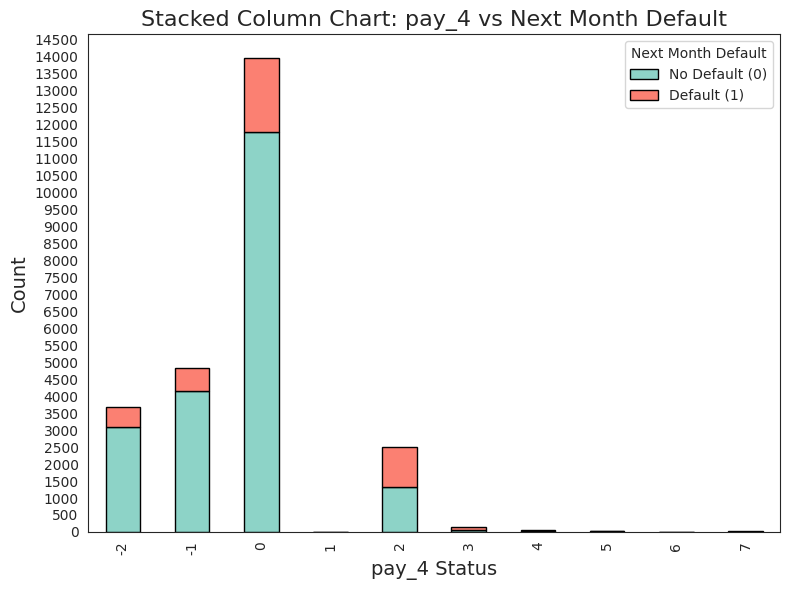

<ipython-input-52-2a64be988afb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train_df.groupby([col, 'next_month_default']).size().unstack(fill_value=0)


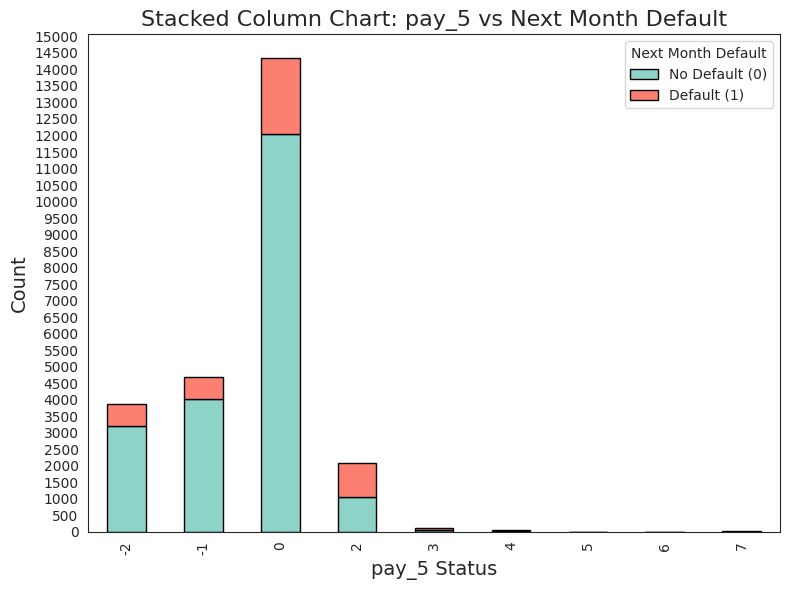

<ipython-input-52-2a64be988afb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train_df.groupby([col, 'next_month_default']).size().unstack(fill_value=0)


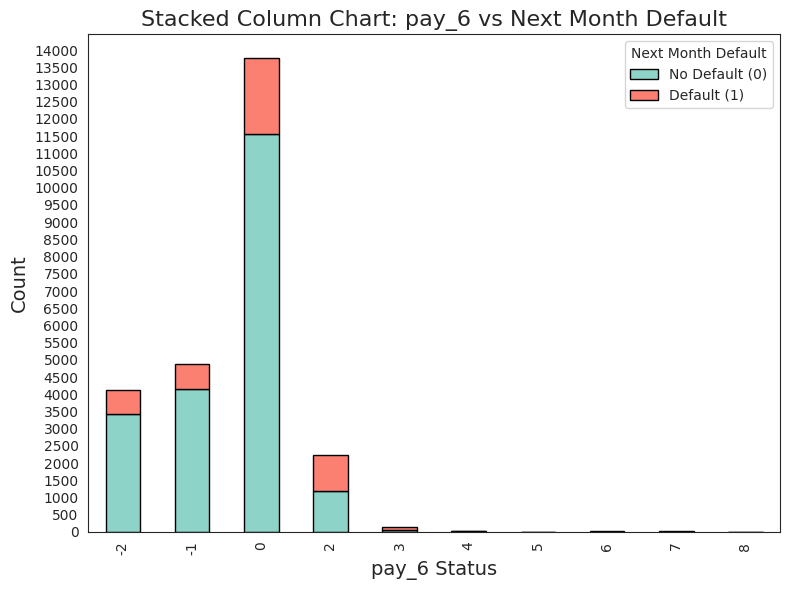

In [52]:
p_cols = ['sex', 'education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

for col in p_cols:
    # Count occurrences of each combination of pay status and default status
    counts = train_df.groupby([col, 'next_month_default']).size().unstack(fill_value=0)
    counts = counts.sort_index()

    # Plot stacked bar chart
    ax=counts.plot(
        kind='bar',
        stacked=True,
        figsize=(8, 6),
        color=['#8dd3c7', '#fb8072'],
        edgecolor='black'
    )
    # Set y-axis ticks at intervals of 500
    max_y = ax.get_ylim()[1]
    ticks = list(range(0, int(max_y) + 500, 500))
    ax.set_yticks(ticks)
    ax.set_ylim(0, max_y)

    plt.title(f'Stacked Column Chart: {col} vs Next Month Default', fontsize=16)
    plt.xlabel(f'{col} Status', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='Next Month Default', labels=['No Default (0)', 'Default (1)'])
    plt.tight_layout()
    plt.show()

### Key Observations:

* Clearly, people who tend to delay their payments by more months tend to default more on the credit than those who are up to date with full/partial payment, even though majority makes partial payment. In other words, those with payment delays also defaulted more often than those with no payment delays or with unknown payment delay status.

* We also see that a woman is more likely to default compared to a man.

* University and high school graduates defaulted more often than people with postgraduate degree and others, which can be explained by increasing debt due to education loans.

* Married poeple defaulted more often than unmarried people.

* People past the middle age (>=55) are more likely to default on the credit.

# Feature Engineering

Here, various features were created from the existing dataset that could help predict the default status next month more accurately.

In [53]:
# Convert default column to numeric for further analysis
train_df['next_month_default'] = train_df['next_month_default'].astype(int)

# Convert demographic columns to strings for further analysis
demographic_cols = ['sex', 'marriage', 'education']
for col in demographic_cols:
    train_df[col] = train_df[col].astype(int)

status_cols = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
for col in status_cols:
    train_df[col] = train_df[col].astype(int)

plt.style.use('default')
fig_count = 0

In [54]:
# Create sophisticated behavioral profiles based on payment patterns
def create_payment_behavior_profile(row):
    pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

    # Count different payment statuses
    no_consumption = (row[pay_cols] == -2).sum()
    full_payments = (row[pay_cols] == -1).sum()
    revolving_credit = (row[pay_cols] == 0).sum()
    delinquent_months = (row[pay_cols] >= 1).sum()

    if delinquent_months >= 4:
        return 'chronic_defaulter'
    elif delinquent_months >= 2 and row['pay_0'] >= 1:
        return 'escalating_risk'
    elif revolving_credit >= 4:
        return 'revolving_user'
    elif full_payments >= 5:
        return 'disciplined_payer'
    elif no_consumption >= 3:
        return 'inactive_user'
    else:
        return 'mixed_behavior'

train_df['behavior_profile'] = train_df.apply(create_payment_behavior_profile, axis=1)

In [55]:
validation_df['behavior_profile'] = validation_df.apply(create_payment_behavior_profile, axis=1)

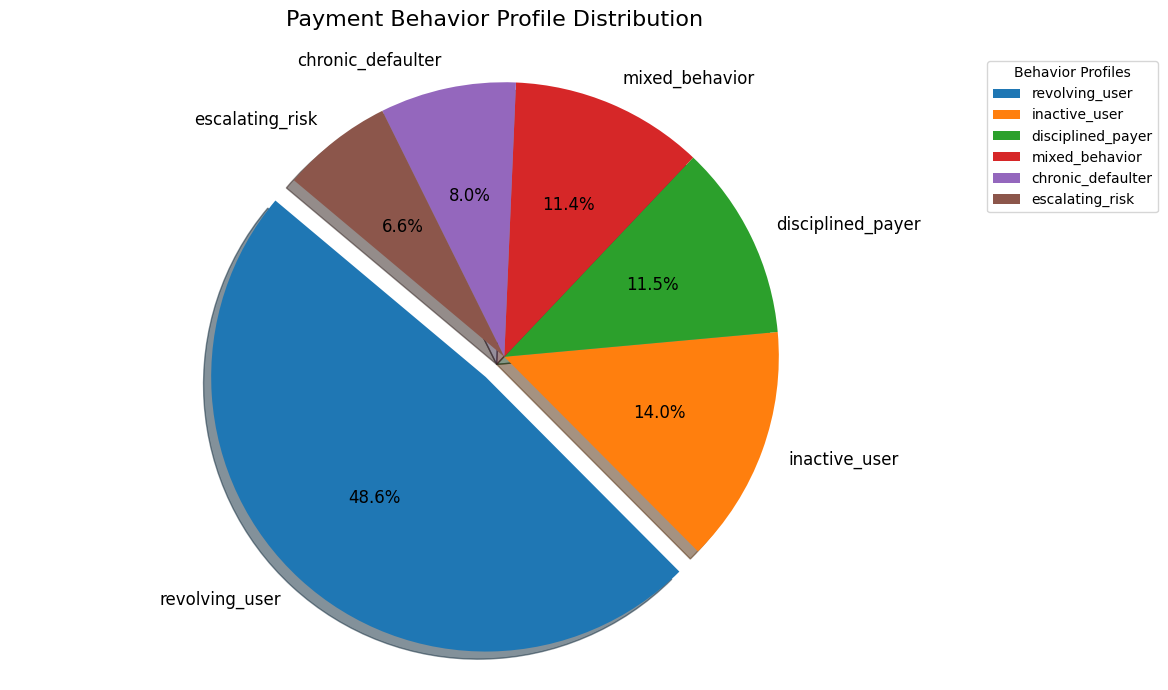

In [56]:
# Get counts and labels
behavior_counts = train_df['behavior_profile'].value_counts()
labels = behavior_counts.index.tolist()
sizes = behavior_counts.values

# Create pie chart with enhanced formatting
plt.figure(figsize=(10, 7))
explode = tuple([0.1 if i == 0 else 0 for i in range(len(labels))])  # Dynamic explode based on number of categories
colors = plt.cm.tab10.colors[:len(labels)]

plt.pie(sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        explode=explode,
        colors=colors,
        shadow=True,
        textprops={'fontsize': 12})

plt.title('Payment Behavior Profile Distribution', fontsize=16, pad=20)
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as circle
plt.tight_layout()

# Add legend for clarity
plt.legend(title="Behavior Profiles",
          loc="upper left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

**Revolving users** dominate (48.6%), representing customers who carry balances month-to-month but maintain regular payments—the bread-and-butter of credit card profitability.

**High-risk** segments combine to 14.6% (chronic_defaulter 8.0% + escalating_risk 6.6%).

The **disciplined_payer** segment (11.5%) represents transactors who pay in full monthly—low risk.

**Mixed_behavior** (11.4%) indicates customers with inconsistent payment patterns, making them prime candidates for targeted intervention before they slide into higher-risk categories.

**Inactive_users** (14.0%) represent dormant accounts that may reactivate unpredictably.

In [57]:
train_df['behavior_profile'] = pd.Categorical(train_df['behavior_profile']).codes

In [58]:
validation_df['behavior_profile'] = pd.Categorical(validation_df['behavior_profile']).codes

In [59]:
eps = 1e-10                                    # avoid div-by-zero
bill_cols   = [f'Bill_amt{i}' for i in range(1, 7)]
pay_cols    = [f'pay_amt{i}'  for i in range(1, 7)]
status_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

### Core Utilisation

In [60]:
train_df['utilisation_latest']  = train_df['Bill_amt1'] /(train_df['LIMIT_BAL']+eps)   # current balance share [1]
train_df['available_credit_ratio'] = 1 - train_df['utilisation_latest']                # head-room share [1]
train_df['limit_per_age']       = train_df['LIMIT_BAL'] /(train_df['age']+1)           # capacity vs age [2]

In [61]:
validation_df['utilisation_latest']       = validation_df['Bill_amt1']/(validation_df['LIMIT_BAL']+eps)   # current usage
validation_df['available_credit_ratio']   = 1 - validation_df['utilisation_latest']                       # spare limit
validation_df['limit_per_age']            = validation_df['LIMIT_BAL']/(validation_df['age']+1)           # capacity vs age

### Repayment/Delinquency

In [62]:
train_df['max_delq']        = train_df[status_cols].max(axis=1)                        # worst ever DPD [3]
train_df['months_delay']    = (train_df[status_cols] > 0).sum(axis=1)                  # #months past-due [3]
train_df['recent_behav']    = train_df[['pay_0', 'pay_2']].mean(axis=1)                # last 2 cycles [4]
train_df['hist_behav']      = train_df[['pay_4', 'pay_5', 'pay_6']].mean(axis=1)       # older cycles [4]
train_df['payment_trend']   = train_df['recent_behav'] - train_df['hist_behav']        # direction [4]
train_df['pay_consistency'] = train_df[status_cols].std(axis=1)                        # volatility [5]

mask = train_df[status_cols].gt(0)                         # 1 = delay, 0 = on-time
# identify streak blocks: increase id whenever previous row has no delay
streak_block = (mask.eq(False).all(axis=1)).cumsum()

# length of the current streak for every row/column
running = mask.groupby(streak_block).cumsum()

# final longest streak length per row
train_df['consecutive_delays'] = running.max(axis=1).fillna(0).astype(int)                                                                               # longest run of DPD [5]

In [63]:
validation_df['max_delq']                 = validation_df[status_cols].max(axis=1)                        # worst DPD
validation_df['months_delay']             = (validation_df[status_cols] > 0).sum(axis=1)                  # # late months
validation_df['recent_behav']             = validation_df[['pay_0','pay_2']].mean(axis=1)                 # last 2
validation_df['hist_behav']               = validation_df[['pay_4','pay_5','pay_6']].mean(axis=1)         # older 3
validation_df['payment_trend']            = validation_df['recent_behav'] - validation_df['hist_behav']   # direction
validation_df['pay_consistency']          = validation_df[status_cols].std(axis=1)                        # σ of DPD


mask = validation_df[status_cols].gt(0)                         # 1 = delay, 0 = on-time
# identify streak blocks: increase id whenever previous row has no delay
streak_block = (mask.eq(False).all(axis=1)).cumsum()

# length of the current streak for every row/column
running = mask.groupby(streak_block).cumsum()

# final longest streak length per row
validation_df['consecutive_delays'] = running.max(axis=1).fillna(0).astype(int)

### Bill/Payment Dynamics

In [64]:
train_df['bill_vol'] = train_df[bill_cols].std(axis=1)                                 # bill σ [6]
train_df['pay_vol']  = train_df[pay_cols].std(axis=1)                                  # pay σ [6]
for i in range(1, 7):
    train_df[f'pay_ratio_{i}'] = train_df[f'pay_amt{i}']/(train_df[f'Bill_amt{i}']+eps) # individual cover [6]

ratio_cols = [f'pay_ratio_{i}' for i in range(1, 7)]
train_df['avg_pay_ratio'] = train_df[ratio_cols].mean(axis=1)                          # mean cover [6]
train_df['min_pay_ratio'] = train_df[ratio_cols].min(axis=1)                           # worst cover [6]
train_df['zero_pay_months'] = (train_df[pay_cols] == 0).sum(axis=1)                    # skipped months [6]

In [65]:
validation_df['bill_vol']                 = validation_df[bill_cols].std(axis=1)
validation_df['pay_vol']                  = validation_df[pay_cols].std(axis=1)

for i in range(1, 7):
    validation_df[f'pay_ratio_{i}']       = validation_df[f'pay_amt{i}']/(validation_df[f'Bill_amt{i}']+eps)

ratio_cols = [f'pay_ratio_{i}' for i in range(1, 7)]
validation_df['avg_pay_ratio']            = validation_df[ratio_cols].mean(axis=1)
validation_df['min_pay_ratio']            = validation_df[ratio_cols].min(axis=1)
validation_df['zero_pay_months']          = (validation_df[pay_cols] == 0).sum(axis=1)

### Payment-Momentum Layer

In [66]:
train_df['payment_momentum'] = (
      train_df['pay_0']*0.4 + train_df['pay_2']*0.25 + train_df['pay_3']*0.2 +
      train_df['pay_4']*0.1 + train_df['pay_5']*0.03 + train_df['pay_6']*0.02 )        # weighted slope [4]
train_df['payment_volatility'] = train_df[status_cols].std(axis=1)                     # σ of DPD [5]

In [67]:
validation_df['payment_momentum'] = (
    validation_df['pay_0']*0.4 + validation_df['pay_2']*0.25 +
    validation_df['pay_3']*0.20 + validation_df['pay_4']*0.10 +
    validation_df['pay_5']*0.03 + validation_df['pay_6']*0.02)

validation_df['payment_volatility'] = validation_df[status_cols].std(axis=1)

### Affordability/Stress

In [68]:
train_df['debt_service_ratio'] = train_df['AVG_Bill_amt']/(train_df['LIMIT_BAL']*0.05+eps) # proxy DSR [7]
train_df['stress_score'] = (
        0.4*train_df['utilisation_latest'] + 0.3*train_df['max_delq'] + 0.3*train_df['months_delay']) # composite [7]
train_df['financial_stability'] = 1/(1+train_df['bill_vol']+train_df['pay_consistency'])             # inverse risk [7]

In [69]:
validation_df['debt_service_ratio']       = validation_df['AVG_Bill_amt']/(validation_df['LIMIT_BAL']*0.05+eps)
validation_df['stress_score']             = (0.4*validation_df['utilisation_latest'] +
                                             0.3*validation_df['max_delq'] +
                                             0.3*validation_df['months_delay'])
validation_df['financial_stability']      = 1/(1+validation_df['bill_vol']+validation_df['pay_consistency'])

### Risk Flags and Segments

In [70]:
train_df['escalating_risk'] = ((train_df['pay_0']>train_df['pay_2']) &
                               (train_df['pay_2']>train_df['pay_3'])).astype(int)       # worsening DPD [8]
train_df['age_risk'] = pd.cut(train_df['age'], bins=[0,25,35,50,65,150], labels=[0,1,2,3,4]).astype(int)  # non-linear age [2]

def assign_risk_tier(row):                                                              # rule-based grade [8]
    if row['months_delay']>=4 and row['utilisation_latest']>0.8: return 'high_risk'
    if row['months_delay']>=2 or row['utilisation_latest']>0.6: return 'medium_risk'
    if row['months_delay']==0 and row['utilisation_latest']<0.3: return 'low_risk'
    return 'moderate_risk'

train_df['risk_tier_encoded'] = (
    pd.Categorical(train_df.apply(assign_risk_tier, axis=1),
                   categories=['low_risk','moderate_risk','medium_risk','high_risk']).codes )          # ordinal tier [8]

def payment_behavior_cluster(r):
    if r['recent_behav']<=0 and r['hist_behav']<=0: return 'always_good'
    if r['recent_behav']>r['hist_behav']          : return 'deteriorating'
    if r['recent_behav']<r['hist_behav']          : return 'improving'
    return 'stable_poor'

train_df['payment_cluster_encoded'] = (
    pd.Categorical(train_df.apply(payment_behavior_cluster,axis=1)).codes )             # 4-level cluster [4]

In [71]:
validation_df['escalating_risk']          = ((validation_df['pay_0']>validation_df['pay_2']) &
                                             (validation_df['pay_2']>validation_df['pay_3'])).astype(int)

validation_df['age_risk'] = pd.cut(validation_df['age'],
                                   bins=[0,25,35,50,65,150],
                                   labels=[0,1,2,3,4]).astype(int)

def assign_risk_tier(r):
    if r['months_delay']>=4 and r['utilisation_latest']>0.8:  return 'high_risk'
    if r['months_delay']>=2 or r['utilisation_latest']>0.6:  return 'medium_risk'
    if r['months_delay']==0 and r['utilisation_latest']<0.3: return 'low_risk'
    return 'moderate_risk'

validation_df['risk_tier_encoded'] = pd.Categorical(
        validation_df.apply(assign_risk_tier, axis=1),
        categories=['low_risk','moderate_risk','medium_risk','high_risk']).codes

def payment_cluster(r):
    if r['recent_behav']<=0 and r['hist_behav']<=0: return 'always_good'
    if r['recent_behav'] > r['hist_behav']        : return 'deteriorating'
    if r['recent_behav'] < r['hist_behav']        : return 'improving'
    return 'stable_poor'

validation_df['payment_cluster_encoded'] = pd.Categorical(
        validation_df.apply(payment_cluster, axis=1)).codes

### Miscellaneous

In [72]:
train_df['payment_shock'] = ((train_df['pay_amt1']<train_df['pay_amt6']*0.5) &
                             (train_df['Bill_amt1']>train_df['Bill_amt6'])).astype(int)                 # sudden drop [8]
train_df['utilization_volatility'] = train_df[bill_cols].std(axis=1)/(train_df['LIMIT_BAL']+eps)        # σ utilisation [6]
train_df['credit_headroom'] = train_df['LIMIT_BAL']-train_df['Bill_amt1']                               # spare credit [1]

train_df["payment_efficiency"] = (
    pd.cut(
        train_df["PAY_TO_BILL_ratio"],
        bins=[-np.inf, 0.3, 0.8, 1.2, np.inf],
        labels=["minimal", "partial", "efficient", "over"]  # keep text labels
    )
    .cat.codes                                           # numeric codes 0-3
)                                      # easy to explain [9]
train_df['spending_discipline'] = 1 - train_df['bill_vol']/(train_df['AVG_Bill_amt']+eps)              # self-control [6]

In [73]:
validation_df['payment_shock']           = ((validation_df['pay_amt1']<validation_df['pay_amt6']*0.5) &
                                             (validation_df['Bill_amt1']>validation_df['Bill_amt6'])).astype(int)
validation_df['utilization_volatility']  = validation_df[bill_cols].std(axis=1)/(validation_df['LIMIT_BAL']+eps)
validation_df['credit_headroom'] = validation_df['LIMIT_BAL']-validation_df['Bill_amt1']
validation_df["payment_efficiency"] = (
    pd.cut(
        validation_df["PAY_TO_BILL_ratio"],
        bins=[-np.inf, 0.3, 0.8, 1.2, np.inf],
        labels=["minimal", "partial", "efficient", "over"]  # keep text labels
    )
    .cat.codes                                           # numeric codes 0-3
)

validation_df['spending_discipline']     = 1 - validation_df['bill_vol']/(validation_df['AVG_Bill_amt']+eps)

In [74]:
cols_to_remove = [
    'avg_delq','hist_behav','bill_trend','payment_acceleration',
    'bill_momentum_short','bill_momentum_long','bill_momentum_ratio',
    'payment_velocity','payment_deceleration','headroom_utilization_trend',
    'limit_efficiency','utilisation_peak','utilisation_avg'
]    #Removing features made solely for intermediate calculations
                                                              # domain-redundant set [8]
train_df.drop(columns=cols_to_remove, inplace=True, errors='ignore')
validation_df.drop(columns=cols_to_remove, inplace=True, errors='ignore')

## Dealing with Multicollinearity amongst Engineered Features

In [75]:
all_engineered_features = [
    'utilisation_latest','available_credit_ratio','limit_per_age',
    'payment_volatility','max_delq','months_delay','recent_behav','payment_trend',
    'pay_consistency','bill_vol','pay_vol','avg_pay_ratio','min_pay_ratio',
    'zero_pay_months','debt_service_ratio','stress_score','escalating_risk',
    'age_risk','credit_headroom','financial_stability','consecutive_delays',
    'payment_shock','risk_tier_encoded','payment_cluster_encoded',
    'payment_momentum','utilization_volatility','payment_efficiency',
    'spending_discipline', 'behavior_profile'
]

target_col = 'next_month_default'

# Filter existing features
cols_to_analyze = [c for c in all_engineered_features]
cols_to_analyze.append(target_col)

corr_matrix = train_df[cols_to_analyze].corr()

### Target Correlation Analysis

In [76]:
print("\n" + "="*80)
print("🎯 CORRELATIONS WITH TARGET VARIABLE (next_month_default)")
print("="*80)

# Extract target correlations
target_correlations = corr_matrix[target_col].drop(target_col).sort_values(ascending=False, key=abs)

# Create detailed correlation table
correlation_df = pd.DataFrame({
    'Feature': target_correlations.index,
    'Correlation': target_correlations.values,
    'Abs_Correlation': np.abs(target_correlations.values),
    'Strength': ['Very Strong (>0.5)' if abs(x) > 0.5 else
                'Strong (0.3-0.5)' if abs(x) > 0.3 else
                'Moderate (0.2-0.3)' if abs(x) > 0.2 else
                'Weak (0.1-0.2)' if abs(x) > 0.1 else
                'Very Weak (<0.1)' for x in target_correlations.values]
})

print(correlation_df.to_string(index=False))


🎯 CORRELATIONS WITH TARGET VARIABLE (next_month_default)
                Feature  Correlation  Abs_Correlation           Strength
           months_delay     0.389616         0.389616   Strong (0.3-0.5)
           stress_score     0.372179         0.372179   Strong (0.3-0.5)
payment_cluster_encoded     0.324779         0.324779   Strong (0.3-0.5)
               max_delq     0.315777         0.315777   Strong (0.3-0.5)
           recent_behav     0.308282         0.308282   Strong (0.3-0.5)
       payment_momentum     0.305571         0.305571   Strong (0.3-0.5)
     consecutive_delays     0.297497         0.297497 Moderate (0.2-0.3)
       behavior_profile    -0.256699         0.256699 Moderate (0.2-0.3)
     payment_volatility     0.234133         0.234133 Moderate (0.2-0.3)
        pay_consistency     0.234133         0.234133 Moderate (0.2-0.3)
      risk_tier_encoded     0.224865         0.224865 Moderate (0.2-0.3)
          limit_per_age    -0.152236         0.152236     Weak (0.

### Identifying Highly Correlated Pairs (Threshold = 0.65)

In [77]:
corr_matrix = train_df[cols_to_analyze].corr()

def find_high_correlations(corr_matrix, threshold=0.65):
    """Find pairs of features with correlation above threshold"""
    high_corr_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            correlation = corr_matrix.iloc[i, j]

            if abs(correlation) > threshold and feature1 != 'next_month_default' and feature2 != 'next_month_default':
                high_corr_pairs.append({
                    'feature1': feature1,
                    'feature2': feature2,
                    'correlation': correlation
                })

    return sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)

# Find high correlations
high_corr_pairs = find_high_correlations(corr_matrix, threshold=0.7)

In [78]:
def select_features_to_eliminate(high_corr_pairs, target_correlations):
    """
    From each highly correlated pair, eliminate the feature with lower target correlation
    """
    features_to_eliminate = set()

    for pair in high_corr_pairs:
        feature1 = pair['feature1']
        feature2 = pair['feature2']

        # Get target correlations
        corr1_target = abs(target_correlations.get(feature1, 0))
        corr2_target = abs(target_correlations.get(feature2, 0))

        # Eliminate the feature with lower target correlation
        if corr1_target < corr2_target:
          features_to_eliminate.add(feature1)
        else:
          features_to_eliminate.add(feature2)

    return list(features_to_eliminate)

# Get target correlations
target_correlations = corr_matrix['next_month_default'].drop('next_month_default').to_dict()

In [79]:
print(f"\n ELIMINATION DECISIONS:")
print("=" * 70)
features_to_eliminate = select_features_to_eliminate(high_corr_pairs, target_correlations)
print(features_to_eliminate)


 ELIMINATION DECISIONS:
['payment_volatility', 'credit_headroom', 'max_delq', 'payment_momentum', 'risk_tier_encoded', 'available_credit_ratio', 'consecutive_delays', 'stress_score', 'debt_service_ratio', 'recent_behav', 'utilisation_latest', 'payment_cluster_encoded', 'pay_consistency']


In [80]:
train_df.drop(columns=features_to_eliminate, inplace=True)

In [81]:
validation_df.drop(columns=features_to_eliminate, inplace=True)

In [82]:
train_df.drop(['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6'], axis=1, inplace=True)

In [83]:
validation_df.drop(['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6'], axis=1, inplace=True)

In [84]:
# Convert default column to categorical for further analysis
train_df['next_month_default'] = train_df['next_month_default'].astype('category')

# Convert demographic columns to categorical for further analysis
demographic_cols = ['sex', 'marriage', 'education']
for col in demographic_cols:
    train_df[col] = train_df[col].astype('category')

status_cols = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
for col in status_cols:
    train_df[col] = train_df[col].astype('category')

plt.style.use('default')

In [85]:
# Convert demographic columns to categorical for further analysis
demographic_cols = ['sex', 'marriage', 'education']
for col in demographic_cols:
    validation_df[col] = validation_df[col].astype('category')

status_cols = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
for col in status_cols:
    validation_df[col] = validation_df[col].astype('category')

plt.style.use('default')

In [86]:
train_df.describe()

,LIMIT_BAL,age,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,...,avg_pay_ratio,min_pay_ratio,zero_pay_months,financial_stability,escalating_risk,age_risk,payment_shock,utilization_volatility,payment_efficiency,spending_discipline
count,25247.000000,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,...,2.524700e+04,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,2.524700e+04
mean,168342.060443,35.431022,5718.624966,6.047352e+03,5288.910651,4865.960834,4906.766828,5270.499287,44896.942424,57.126134,...,3.227587e+12,3.991959e+08,0.621183,0.022708,0.005822,1.385551,0.111261,0.098217,0.603636,-9.701710e+03
std,129892.784807,9.152635,16806.842125,2.400962e+04,17851.879609,15979.116544,15860.726852,17960.816915,62807.602568,5504.956238,...,3.255704e+13,6.292607e+10,1.038760,0.113317,0.076084,0.807727,0.314461,0.131248,0.912790,8.124509e+05
min,10000.000000,21.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,-8.164966e+07
25%,50000.000000,28.000000,999.985000,9.219100e+02,399.990000,300.150000,262.365000,130.070000,4897.425000,0.040000,...,4.579941e-02,0.000000e+00,0.000000,0.000069,0.000000,1.000000,0.000000,0.014414,0.000000,8.087831e-02
50%,140000.000000,34.000000,2145.020000,2.026830e+03,1844.300000,1500.100000,1513.790000,1500.040000,21112.810000,0.100000,...,1.754228e-01,3.402814e-03,0.000000,0.000215,0.000000,1.000000,0.000000,0.041445,0.000000,5.916490e-01
75%,240000.000000,41.000000,5031.150000,5.000190e+03,4600.640000,4014.990000,4099.890000,4018.780000,57142.730000,0.630000,...,4.380689e+00,3.510428e-02,1.000000,0.000642,0.000000,2.000000,0.000000,0.135505,1.000000,8.980945e-01
max,1000000.000000,79.000000,873551.980000,1.684259e+06,896040.150000,621000.080000,426529.180000,528666.150000,877314.080000,852634.320000,...,2.807099e+15,9.998200e+12,6.000000,1.000000,1.000000,4.000000,1.000000,4.230148,3.000000,1.000000e+00


# Train-Test Split

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score
import shap

import warnings
warnings.filterwarnings("ignore")

#### One-hot Encoding and Scaling

In [88]:
# Separate features and target
X = train_df.drop(columns=['next_month_default'])
y = train_df['next_month_default'].astype(int)

# Standard 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# One-hot encode categorical columns
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Ensure the same columns in test as train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Scale features (important for models like Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Keep scaled DataFrames for later feature naming
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

Train size: 20197 (80.0%)
Test size: 5050 (20.0%)


#### Elimination of Multicollinearity (>0.65)

In [89]:
# Compute absolute Pearson correlation of each feature with the target
target_corr = X_train_scaled_df.apply(lambda col: np.corrcoef(col, y_train)[0, 1]).abs()

# Compute feature-feature correlation matrix
corr_matrix = X_train_scaled_df.corr().abs()

# Extract upper triangle (to avoid duplicate pairs)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop the feature with lower correlation to the target in each correlated pair
to_drop = set()

for col in upper_tri.columns:
    for row in upper_tri.index:
        if pd.notnull(upper_tri.loc[row, col]) and upper_tri.loc[row, col] > 0.65:
            if target_corr[row] < target_corr[col]:
                to_drop.add(row)
            else:
                to_drop.add(col)

print(f"Columns dropped due to high inter-feature correlation and lower target relevance:\n{sorted(to_drop)}")

# Drop from both training and test sets
X_train_reduced = X_train_scaled_df.drop(columns=to_drop)
X_test_reduced = X_test_scaled_df.drop(columns=to_drop)

Columns dropped due to high inter-feature correlation and lower target relevance:
['LIMIT_BAL', 'age_risk', 'pay_0_-1', 'pay_0_0', 'pay_0_6', 'pay_0_7', 'pay_0_8', 'pay_2_-1', 'pay_2_0', 'pay_2_2', 'pay_2_6', 'pay_2_7', 'pay_2_8', 'pay_3_0', 'pay_3_1', 'pay_3_2', 'pay_3_6', 'pay_4_-1', 'pay_4_0', 'pay_4_2', 'pay_4_7', 'pay_5_-1', 'pay_5_0', 'pay_5_2', 'pay_6_-1', 'pay_6_0', 'pay_6_7', 'pay_ratio_2']


# Feature Selection By Random Forest Feature Importance

In [90]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           fbeta_score, roc_curve, precision_recall_curve,
                           make_scorer, accuracy_score, precision_score, recall_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from scipy.stats import uniform, randint, loguniform
import warnings
warnings.filterwarnings('ignore')

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train_reduced, y_train)

selector = SelectFromModel(rf, prefit=True, threshold="median")   # keep best 50 %
tree_cols = X_train_reduced.columns[selector.get_support()]

In [92]:
# 1. Pull raw importances from the fitted forest
importances = rf.feature_importances_            # array length = n_columns

# 2. Build a DataFrame
imp_df = pd.DataFrame({
    'Feature'   : X_train_reduced.columns,
    'Importance': importances
})

# 3. Sort descending and reset the index
imp_df_sorted = (imp_df
                 .sort_values('Importance', ascending=False)
                 .reset_index(drop=True))

print("All features ranked by RF importance:")
display(imp_df_sorted)                           # Jupyter/Colab-friendly

# 4. Show only the variables that survived the median threshold (optional)
selected_imp = imp_df_sorted[imp_df_sorted.Feature.isin(tree_cols)]
print("\nFeatures retained by SelectFromModel (median threshold):")
display(selected_imp)

All features ranked by RF importance:


,Feature,Importance
0,limit_per_age,0.051760
1,months_delay,0.051118
2,spending_discipline,0.050801
3,utilization_volatility,0.050046
4,AVG_Bill_amt,0.049349
...,...,...
61,pay_4_6,0.000037
62,pay_4_1,0.000011
63,pay_3_8,0.000006
64,pay_5_6,0.000003



Features retained by SelectFromModel (median threshold):


,Feature,Importance
0,limit_per_age,0.051760
1,months_delay,0.051118
2,spending_discipline,0.050801
3,utilization_volatility,0.050046
4,AVG_Bill_amt,0.049349
5,pay_vol,0.048964
6,financial_stability,0.048917
7,bill_vol,0.048844
8,pay_0_2,0.047358
9,pay_amt1,0.046465


In [93]:
# Filter train and test to consensus features
X_train_final = X_train_reduced[tree_cols]   #final_features]
X_test_final = X_test_reduced[tree_cols]   #final_features]

### Handling Class Imbalance with SMOTE

In [95]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

# Apply SMOTE on the reduced training set
#smote = SMOTE(random_state=42)
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train_final, y_train)


pipe = Pipeline([
    ('sm', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Fit once to create the synthetic samples
pipe.named_steps['sm'].fit_resample(X_train_final, y_train)
X_train_balanced, y_train_balanced = \
    pipe.named_steps['sm'].fit_resample(X_train_final, y_train)

# Now you can still call:
pipe.fit(X_train_balanced, y_train_balanced)

# Print class distribution after resampling
print("After SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

After SMOTE:
next_month_default
0    16352
1    16352
Name: count, dtype: int64


# Training and Evaluation of Models

In [96]:
# Global results storage
model_results = []
trained_models = {}

In [97]:
# F2 scorer
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

f2_scorer = make_scorer(f2_score)

In [98]:
# CV setup
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

## Common Evaluation Function

In [99]:
def evaluate_model_with_threshold_optimization(model, X_test, y_test):
    """Comprehensive model evaluation with threshold optimization"""
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    # Optimize threshold for F2
    thresholds = np.arange(0.1, 0.9, 0.02)
    best_f2 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        f2 = f2_score(y_test, y_pred)
        if f2 > best_f2:
            best_f2 = f2
            best_threshold = threshold

    # Final predictions with optimal threshold
    y_pred_optimal = (y_proba >= best_threshold).astype(int)

    return {
        'auc': roc_auc_score(y_test, y_proba),
        'f2_score': best_f2,
        'recall': recall_score(y_test, y_pred_optimal),
        'precision': precision_score(y_test, y_pred_optimal),
        'accuracy': accuracy_score(y_test, y_pred_optimal),
        'optimal_threshold': best_threshold,
        'y_proba': y_proba,
        'y_pred': y_pred_optimal
    }

### Logistic Regression Training

In [100]:
# Model configuration
lr_model = LogisticRegression(random_state=42, max_iter=2000)
lr_param_space = {
    'C': loguniform(0.001, 100),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

In [101]:
# Randomized search
lr_search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=lr_param_space,
    n_iter=50,
    cv=cv,
    scoring=f2_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

In [102]:
# Train
lr_search.fit(X_train_balanced, y_train_balanced)
best_lr = lr_search.best_estimator_
trained_models['Logistic_Regression'] = best_lr

# Evaluate
lr_results = evaluate_model_with_threshold_optimization(best_lr, X_test_final, y_test)

In [103]:
from sklearn.metrics import f1_score

In [104]:
# Store results
lr_result = {
    'Model': 'Logistic_Regression',
    'Best_CV_F2': lr_search.best_score_,
    'Test_AUC': lr_results['auc'],
    'Test_F2': lr_results['f2_score'],
    'Test_F1': f1_score(y_test, lr_results['y_pred']),
    'Test_Recall': lr_results['recall'],
    'Test_Precision': lr_results['precision'],
    'Test_Accuracy': lr_results['accuracy'],
    'Optimal_Threshold': lr_results['optimal_threshold']
}

model_results.append(lr_result)

In [105]:
# Final result display
print(f" Logistic Regression completed!")
print(f"   CV F2: {lr_search.best_score_:.4f}")
print(f"   Test F2: {lr_results['f2_score']:.4f}")
print(f"   Test F1: {f1_score(y_test, lr_results['y_pred']):.4f}")
print(f"   Test AUC: {lr_results['auc']:.4f}")
print(f"   Test Recall: {lr_results['recall']:.4f}"),
print(f"   Test Precision: {lr_results['precision']:.4f}"),
print(f"   Test Accuracy: {lr_results['accuracy']:.4f}"),
print(f"   Optimal Threshold: {lr_results['optimal_threshold']:.3f}")

 Logistic Regression completed!
   CV F2: 0.6192
   Test F2: 0.6096
   Test F1: 0.4714
   Test AUC: 0.7814
   Test Recall: 0.7578
   Test Precision: 0.3421
   Test Accuracy: 0.6762
   Optimal Threshold: 0.400


### Decision Tree Training

In [106]:
# Model configuration
dt_model = DecisionTreeClassifier(random_state=42)
dt_param_space = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 15),
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced'],
    'ccp_alpha': uniform(0.0, 0.02)
}

In [107]:
# Randomized search
dt_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=dt_param_space,
    n_iter=40,
    cv=cv,
    scoring=f2_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

In [108]:
# Train
dt_search.fit(X_train_balanced, y_train_balanced)
best_dt = dt_search.best_estimator_
trained_models['Decision_Tree'] = best_dt

# Evaluate
dt_results = evaluate_model_with_threshold_optimization(best_dt, X_test_final, y_test)

In [109]:
# Store results
dt_result = {
    'Model': 'Decision_Tree',
    'Best_CV_F2': dt_search.best_score_,
    'Test_AUC': dt_results['auc'],
    'Test_F2': dt_results['f2_score'],
    'Test_F1': f1_score(y_test, dt_results['y_pred']),
    'Test_Recall': dt_results['recall'],
    'Test_Precision': dt_results['precision'],
    'Test_Accuracy': dt_results['accuracy'],
    'Optimal_Threshold': dt_results['optimal_threshold']
}

model_results.append(dt_result)

In [110]:
# Final result display
print(f" Decision Tree completed!")
print(f"   CV F2: {dt_search.best_score_:.4f}")
print(f"   Test F2: {dt_results['f2_score']:.4f}")
print(f"   Test F1: {f1_score(y_test, dt_results['y_pred']):.4f}")
print(f"   Test AUC: {dt_results['auc']:.4f}")
print(f"   Test Recall: {dt_results['recall']:.4f}"),
print(f"   Test Precision: {dt_results['precision']:.4f}")
print(f"   Test Accuracy: {dt_results['accuracy']:.4f}")
print(f"   Optimal Threshold: {dt_results['optimal_threshold']:.3f}")

 Decision Tree completed!
   CV F2: 0.7413
   Test F2: 0.5719
   Test F1: 0.4200
   Test AUC: 0.7343
   Test Recall: 0.7536
   Test Precision: 0.2912
   Test Accuracy: 0.6036
   Optimal Threshold: 0.200


### Random Forest Training

In [111]:
# Model configuration
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_param_space = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [8, 12, None],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 8, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

In [112]:
# Randomized search
rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_space,
    n_iter=25,
    cv=cv,
    scoring=f2_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

In [113]:
# Train
rf_search.fit(X_train_balanced, y_train_balanced)
best_rf = rf_search.best_estimator_
trained_models['Random_Forest'] = best_rf

# Evaluate
rf_results = evaluate_model_with_threshold_optimization(best_rf, X_test_final, y_test)

In [114]:
# Store results
rf_result = {
    'Model': 'Random_Forest',
    'Best_CV_F2': rf_search.best_score_,
    'Test_AUC': rf_results['auc'],
    'Test_F2': rf_results['f2_score'],
    'Test_F1': f1_score(y_test, rf_results['y_pred']),
    'Test_Recall': rf_results['recall'],
    'Test_Precision': rf_results['precision'],
    'Test_Accuracy': rf_results['accuracy'],
    'Optimal_Threshold': rf_results['optimal_threshold']
}

model_results.append(rf_result)

In [115]:
# Final result display
print(f" Random Forest completed!")
print(f"   CV F2: {rf_search.best_score_:.4f}")
print(f"   Test F2: {rf_results['f2_score']:.4f}")
print(f"   Test F1: {f1_score(y_test, rf_results['y_pred']):.4f}")
print(f"   Test AUC: {rf_results['auc']:.4f}")
print(f"   Test Recall: {rf_results['recall']:.4f}")
print(f"   Test Precision: {rf_results['precision']:.4f}")
print(f"   Test Accuracy: {rf_results['accuracy']:.4f}")
print(f"   Optimal Threshold: {rf_results['optimal_threshold']:.3f}")

 Random Forest completed!
   CV F2: 0.8329
   Test F2: 0.6045
   Test F1: 0.4228
   Test AUC: 0.7812
   Test Recall: 0.8472
   Test Precision: 0.2817
   Test Accuracy: 0.5594
   Optimal Threshold: 0.220


### Training XGBoost

In [116]:
# Model configuration
xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_param_space = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [1, 2, 3]
}

In [117]:
# Randomized search
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_space,
    n_iter=30,
    cv=cv,
    scoring=f2_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

In [118]:
# Train
xgb_search.fit(X_train_balanced, y_train_balanced)
best_xgb = xgb_search.best_estimator_
trained_models['XGBoost'] = best_xgb

# Evaluate
xgb_results = evaluate_model_with_threshold_optimization(best_xgb, X_test_final, y_test)

In [119]:
# Store results
xgb_result = {
    'Model': 'XGBoost',
    'Best_CV_F2': xgb_search.best_score_,
    'Test_AUC': xgb_results['auc'],
    'Test_F2': xgb_results['f2_score'],
    'Test_F1': f1_score(y_test, xgb_results['y_pred']),
    'Test_Recall': xgb_results['recall'],
    'Test_Precision': xgb_results['precision'],
    'Test_Accuracy': xgb_results['accuracy'],
    'Optimal_Threshold': xgb_results['optimal_threshold']
}

model_results.append(xgb_result)

In [120]:
# Final result display
print(f" XGBoost completed!")
print(f"   CV F2: {xgb_search.best_score_:.4f}")
print(f"   Test F2: {xgb_results['f2_score']:.4f}")
print(f"   Test F1: {f1_score(y_test, xgb_results['y_pred']):.4f}")
print(f"   Test AUC: {xgb_results['auc']:.4f}")
print(f"   Test Recall: {xgb_results['recall']:.4f}"),
print(f"   Test Precision: {xgb_results['precision']:.4f}")
print(f"   Test Accuracy: {xgb_results['accuracy']:.4f}")
print(f"   Optimal Threshold: {xgb_results['optimal_threshold']:.3f}")

 XGBoost completed!
   CV F2: 0.8927
   Test F2: 0.5944
   Test F1: 0.4387
   Test AUC: 0.7635
   Test Recall: 0.7786
   Test Precision: 0.3053
   Test Accuracy: 0.6204
   Optimal Threshold: 0.240


### Training LightGBM

In [121]:
# Model configuration
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_param_space = {
    'n_estimators': [100, 200, 300, 500],
    'num_leaves': [31, 50, 70],
    'max_depth': [6, 8, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
    'min_child_samples': [10, 20, 30]
}

In [122]:
# Randomized search
lgb_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_param_space,
    n_iter=30,
    cv=cv,
    scoring=f2_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

In [123]:
# Train
lgb_search.fit(X_train_balanced, y_train_balanced)
best_lgb = lgb_search.best_estimator_
trained_models['LightGBM'] = best_lgb

# Evaluate
lgb_results = evaluate_model_with_threshold_optimization(best_lgb, X_test_final, y_test)

In [124]:
# Store results
lgb_result = {
    'Model': 'LightGBM',
    'Best_CV_F2': lgb_search.best_score_,
    'Test_AUC': lgb_results['auc'],
    'Test_F2': lgb_results['f2_score'],
    'Test_F1': f1_score(y_test, lgb_results['y_pred']),
    'Test_Recall': lgb_results['recall'],
    'Test_Precision': lgb_results['precision'],
    'Test_Accuracy': lgb_results['accuracy'],
    'Optimal_Threshold': lgb_results['optimal_threshold']
}

model_results.append(lgb_result)

In [125]:
# Final result display
print(f" LightGBM completed!")
print(f"   CV F2: {lgb_search.best_score_:.4f}")
print(f"   Test F2: {lgb_results['f2_score']:.4f}")
print(f"   Test F1: {f1_score(y_test, lgb_results['y_pred']):.4f}")
print(f"   Test AUC: {lgb_results['auc']:.4f}")
print(f"   Test Recall: {lgb_results['recall']:.4f}"),
print(f"   Test Precision: {lgb_results['precision']:.4f}")
print(f"   Test Accuracy: {lgb_results['accuracy']:.4f}")
print(f"   Optimal Threshold: {lgb_results['optimal_threshold']:.3f}")

 LightGBM completed!
   CV F2: 0.8662
   Test F2: 0.5954
   Test F1: 0.4302
   Test AUC: 0.7632
   Test Recall: 0.8004
   Test Precision: 0.2941
   Test Accuracy: 0.5960
   Optimal Threshold: 0.100


# Result Summary:

In [126]:
# Create results DataFrame
results_df = pd.DataFrame(model_results)
results_summary = results_df.sort_values('Test_F2', ascending=False)

### Best Model Details

In [127]:
# Best model details
best_model = results_summary.iloc[0]
print(f"\n  BEST MODEL: {best_model['Model']}")
print(f"   F2 Score: {best_model['Test_F2']:.4f}")
print(f"   F1 Score: {best_model['Test_F1']:.4f}")
print(f"   AUC Score: {best_model['Test_AUC']:.4f}")
print(f"   Recall: {best_model['Test_Recall']:.4f}")
print(f"   Precision: {best_model['Test_Precision']:.4f}")
print(f"   Accuracy: {best_model['Test_Accuracy']:.4f}")
print(f"   Optimal Threshold: {best_model['Optimal_Threshold']:.3f}")


  BEST MODEL: Logistic_Regression
   F2 Score: 0.6096
   F1 Score: 0.4714
   AUC Score: 0.7814
   Recall: 0.7578
   Precision: 0.3421
   Accuracy: 0.6762
   Optimal Threshold: 0.400


### Model Rankings

In [128]:
print("\n" + "="*105)
print("📊 MODEL RANKINGS")
print("="*105)

# Create a formatted table header
print(f"{'Rank':<6}{'Model':<20}{'F2':<10}{'F1':<10}{'AUC':<10}{'Recall':<12}{'Precision':<15}{'Accuracy':<12}{'Threshold':<16}")
print("-" * 105)

# Display each model in table format
for i, row in results_summary.iterrows():
    rank = i + 1
    print(f"{rank:<6}{row['Model']:<20}{row['Test_F2']:<10.4f}{row['Test_F1']:<10.4f}{row['Test_AUC']:<10.4f}{row['Test_Recall']:<12.4f}{row['Test_Precision']:<15.4f}{row['Test_Accuracy']:<12.4f}{row['Optimal_Threshold']:<16.2f}")

print("\n" + "="*105)


📊 MODEL RANKINGS
Rank  Model               F2        F1        AUC       Recall      Precision      Accuracy    Threshold       
---------------------------------------------------------------------------------------------------------
1     Logistic_Regression 0.6096    0.4714    0.7814    0.7578      0.3421         0.6762      0.40            
3     Random_Forest       0.6045    0.4228    0.7812    0.8472      0.2817         0.5594      0.22            
5     LightGBM            0.5954    0.4302    0.7632    0.8004      0.2941         0.5960      0.10            
4     XGBoost             0.5944    0.4387    0.7635    0.7786      0.3053         0.6204      0.24            
2     Decision_Tree       0.5719    0.4200    0.7343    0.7536      0.2912         0.6036      0.20            



### Feature Importance for Best Model

In [129]:
# Get best model for feature importance
best_model_name = results_summary.iloc[0]['Model']
if best_model_name in trained_models and hasattr(trained_models[best_model_name], 'feature_importances_'):

    plt.figure(figsize=(12, 8))

    model = trained_models[best_model_name]
    importances = model.feature_importances_

    # Create DataFrame and sort
    feature_df = pd.DataFrame({
        'Feature': X_test_final.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=True)  # ascending for horizontal plot

    # Take top 10
    top_10 = feature_df.tail(10)

    # Create horizontal bar plot
    plt.barh(range(len(top_10)), top_10['Importance'], color='skyblue', alpha=0.8)
    plt.yticks(range(len(top_10)), top_10['Feature'], fontsize=10)
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 10 Features - {best_model_name}', fontsize=14, pad=20)
    plt.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (idx, row) in enumerate(top_10.iterrows()):
        plt.text(row['Importance'] + 0.001, i, f'{row["Importance"]:.3f}',
                va='center', fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for best model")

Feature importance not available for best model


### Model Performance Comparison

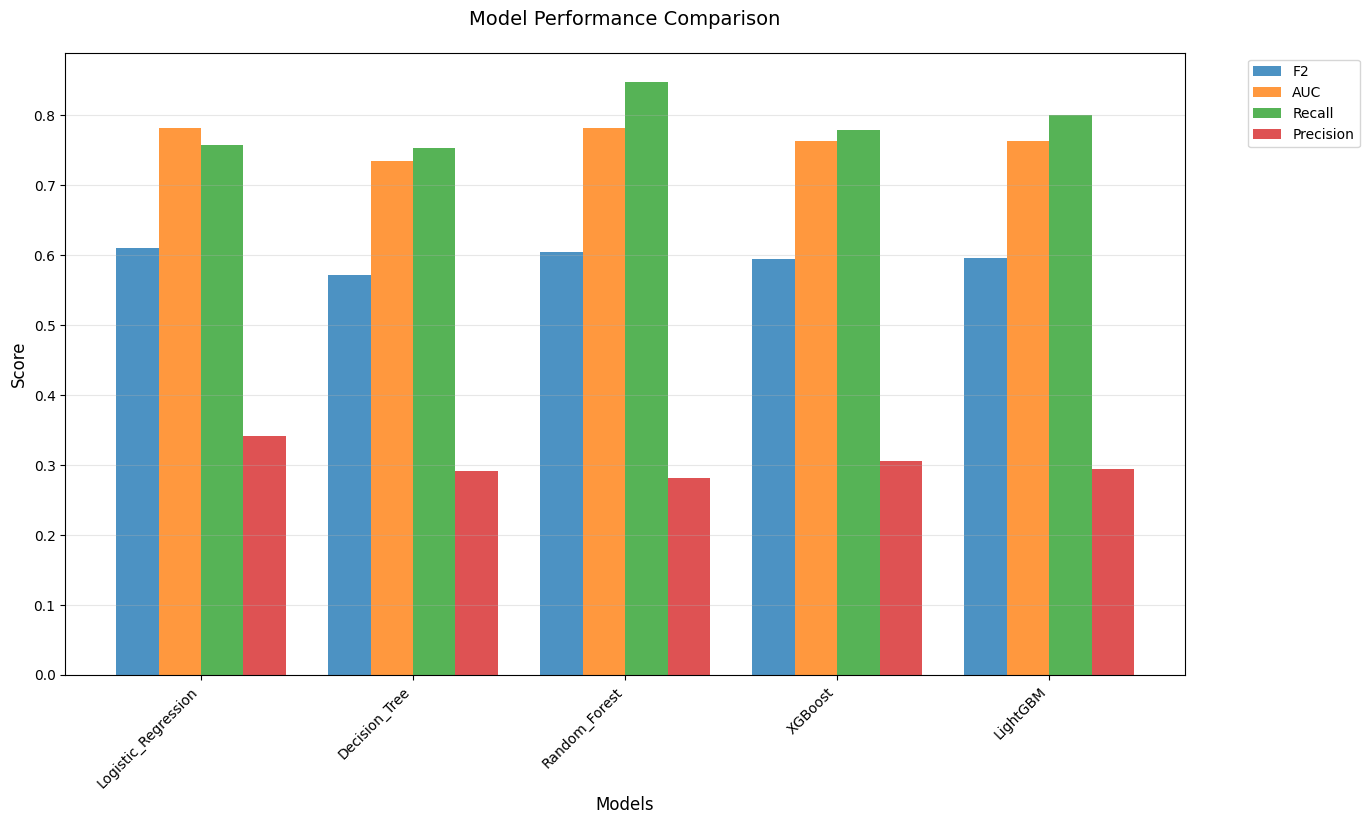

In [130]:
plt.figure(figsize=(14, 8))

metrics = ['Test_F2', 'Test_AUC', 'Test_Recall', 'Test_Precision']
x = np.arange(len(results_df))
width = 0.2

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, results_df[metric], width,
           label=metric.replace('Test_', ''), alpha=0.8, color=colors[i])

plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, pad=20)

# FIX: Rotate labels to prevent overlap
plt.xticks(x + width*1.5, results_df['Model'],
           rotation=45, ha='right', fontsize=10)  # 45-degree rotation

plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.subplots_adjust(right=0.85, bottom=0.15)  # Extra bottom space for rotated labels
plt.show()

### Precision vs Recall

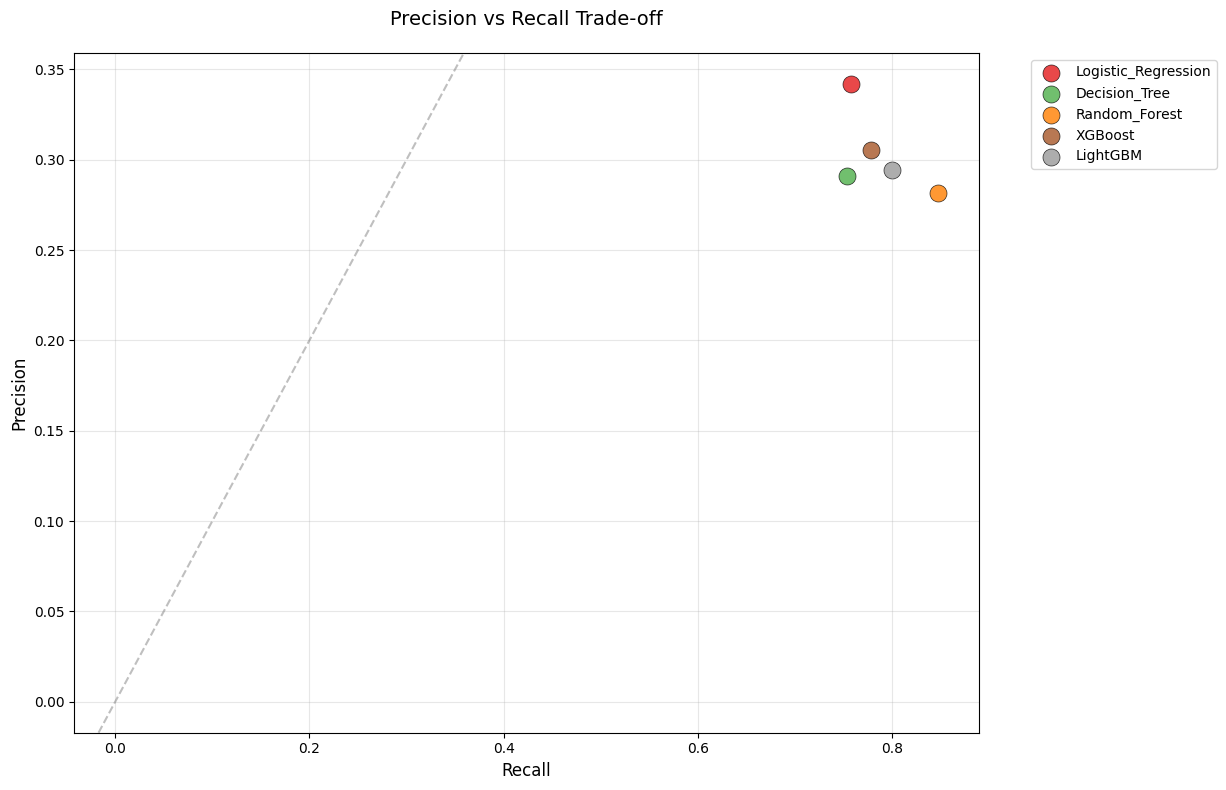

In [131]:
plt.figure(figsize=(12, 8))

# Create scatter plot with different colors for each model
colors = plt.cm.Set1(np.linspace(0, 1, len(results_df)))

for i, row in results_df.iterrows():
    plt.scatter(row['Test_Recall'], row['Test_Precision'],
               s=150, alpha=0.8, c=[colors[i]],
               label=row['Model'], edgecolors='black', linewidth=0.5)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision vs Recall Trade-off', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add diagonal lines for reference
plt.axline((0, 0), slope=1, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.subplots_adjust(right=0.82)  # Make room for legend
plt.show()

### Confusion Matrices

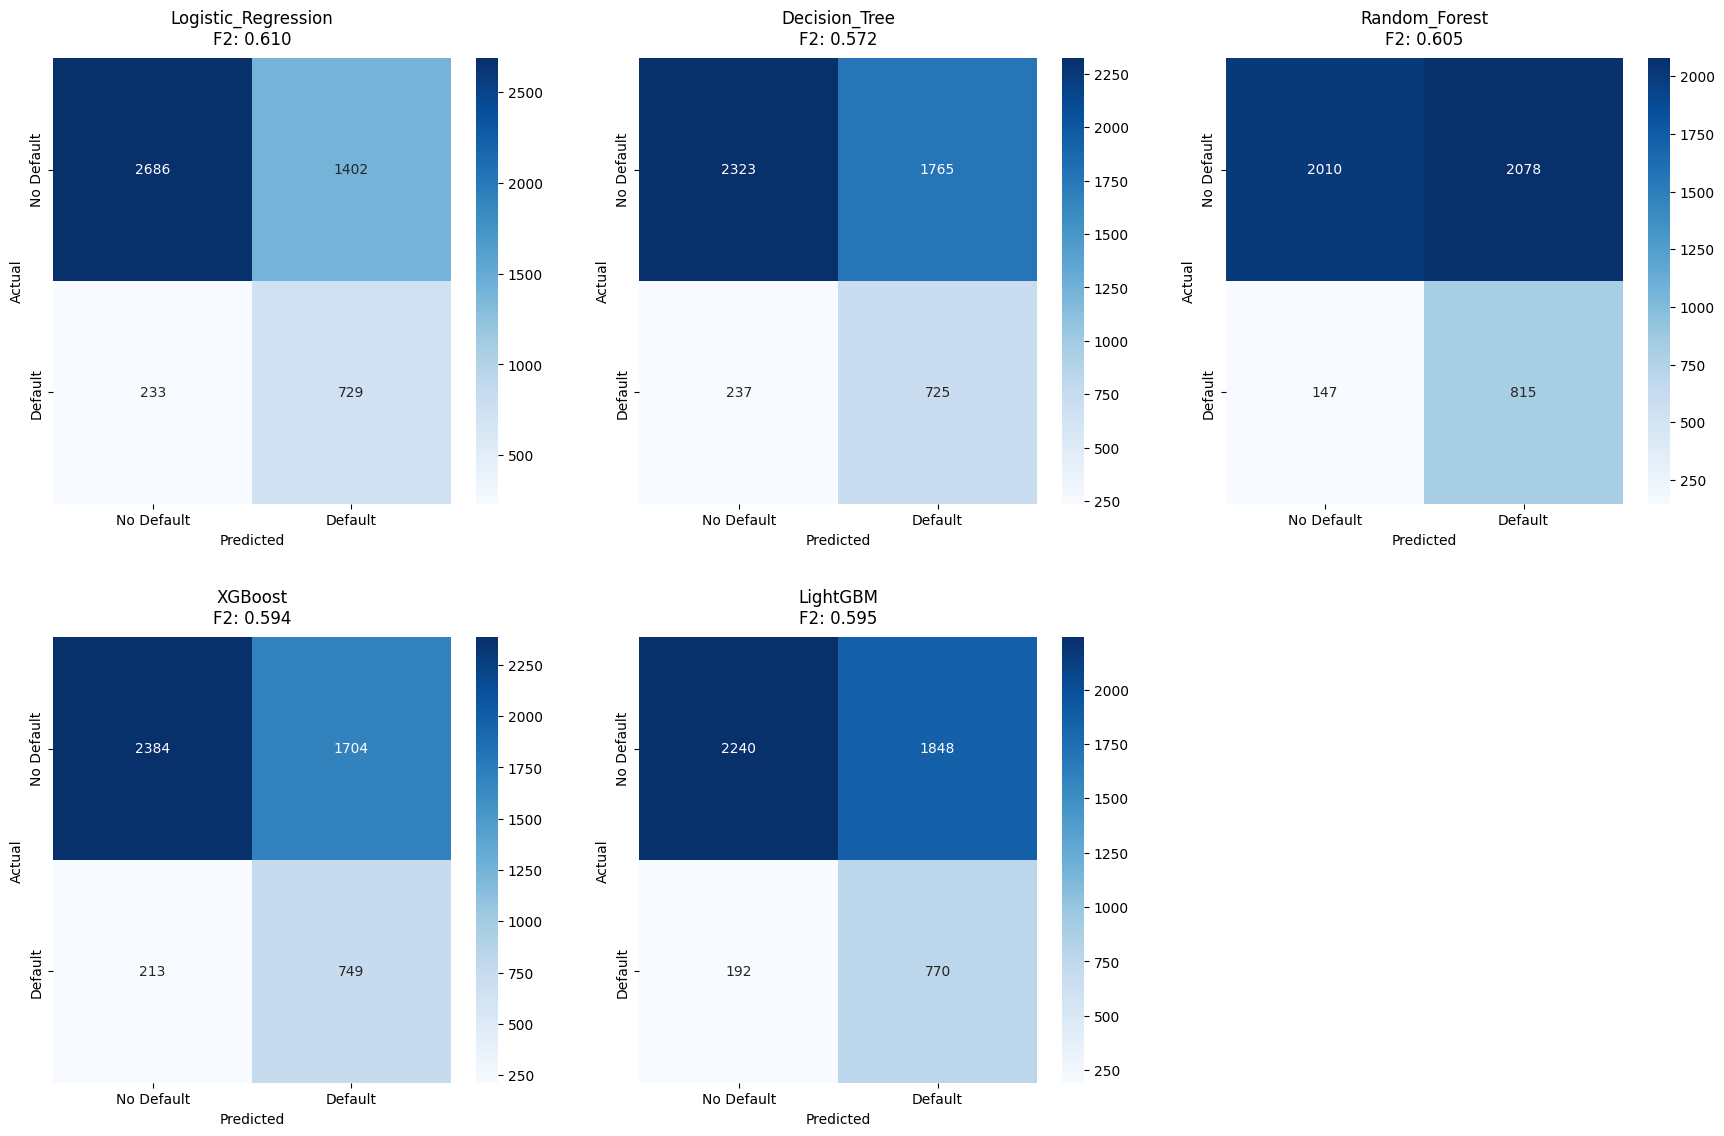

In [132]:
n_models = len(trained_models)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (model_name, model) in enumerate(trained_models.items()):
    if idx < len(axes):
        eval_results = evaluate_model_with_threshold_optimization(model, X_test_final, y_test)
        cm = confusion_matrix(y_test, eval_results['y_pred'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Default', 'Default'],
                   yticklabels=['No Default', 'Default'],
                   ax=axes[idx], cbar=True)

        axes[idx].set_title(f'{model_name}\nF2: {eval_results["f2_score"]:.3f}',
                           fontsize=12, pad=10)
        axes[idx].set_xlabel('Predicted', fontsize=10)
        axes[idx].set_ylabel('Actual', fontsize=10)

# Hide empty subplots
for idx in range(len(trained_models), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout(pad=3.0)
plt.show()

### ROC Curves

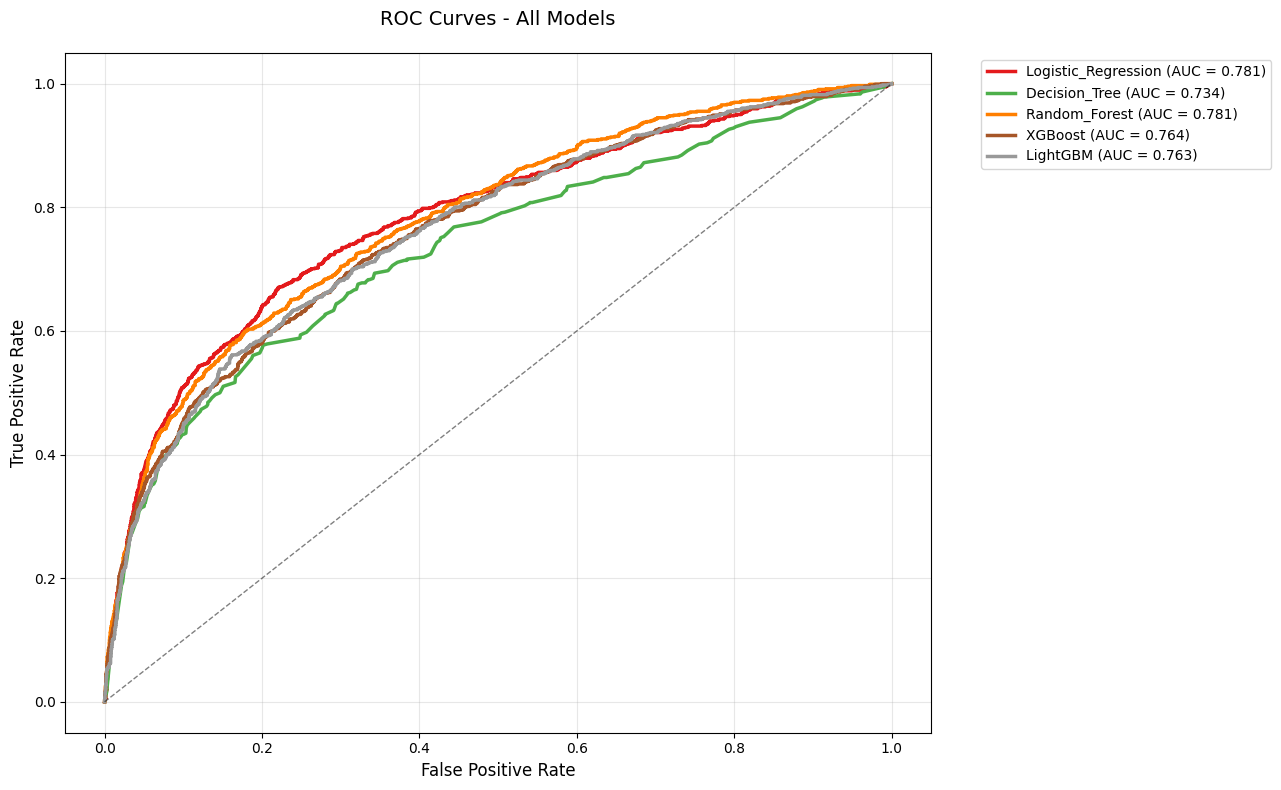

In [133]:
plt.figure(figsize=(12, 8))

colors = plt.cm.Set1(np.linspace(0, 1, len(trained_models)))

for idx, (model_name, model) in enumerate(trained_models.items()):
    eval_results = evaluate_model_with_threshold_optimization(model, X_test_final, y_test)

    fpr, tpr, _ = roc_curve(y_test, eval_results['y_proba'])
    plt.plot(fpr, tpr, linewidth=2.5, color=colors[idx],
            label=f'{model_name} (AUC = {eval_results["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(right=0.78)
plt.show()

# Storing Predictions in Validation Dataset

In [134]:
cust_id = validation_df['Customer_ID']
X_val_raw = validation_df.drop(columns=['Customer_ID'])

In [135]:
# ----------------------------------------------------------------------------
# One-hot, align, scale, and keep the final feature list in validation dataset
# ----------------------------------------------------------------------------
# one-hot encoding
X_val_oh = pd.get_dummies(X_val_raw, drop_first=True)
X_val_oh = X_val_oh.reindex(columns=X_train.columns, fill_value=0)

# scale with the *training* scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_val_oh)
X_val_scaled = scaler.transform(X_val_oh)

X_val_scaled = pd.DataFrame(X_val_scaled,
                            columns=X_train.columns,
                            index=X_val_oh.index)

# drop the same correlated columns
X_val_reduced = X_val_scaled.drop(columns=to_drop)

X_val_final  = X_val_reduced[tree_cols]

In [136]:
X_val_reduced.head()

,age,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,behavior_profile,...,pay_5_4,pay_5_5,pay_5_6,pay_5_7,pay_6_2,pay_6_3,pay_6_4,pay_6_5,pay_6_6,pay_6_8
0,-0.367143,-0.245709,-0.079506,-0.235183,-0.181351,-0.112753,1.519181,-0.347086,-0.033006,0.834268,...,-0.054767,-0.024463,0.0,-0.024463,-0.311244,-0.077568,-0.039968,-0.019972,-0.014121,0.0
1,-0.041256,2.089066,0.340519,-0.081916,-0.282982,-0.196759,1.255975,-0.497326,-0.029145,0.254591,...,-0.054767,-0.024463,0.0,-0.024463,-0.311244,-0.077568,-0.039968,-0.019972,-0.014121,0.0
2,0.393261,0.415161,0.143048,0.504434,0.279084,0.297001,0.287469,3.250550,-0.034518,0.834268,...,-0.054767,-0.024463,0.0,-0.024463,-0.311244,-0.077568,-0.039968,-0.019972,-0.014121,0.0
3,1.262295,-0.304280,-0.120595,-0.318645,-0.210130,-0.288374,-0.245775,-0.502340,-0.034294,0.254591,...,-0.054767,-0.024463,0.0,-0.024463,3.212911,-0.077568,-0.039968,-0.019972,-0.014121,0.0
4,-0.584402,1.472110,1.259097,0.123567,0.225274,0.229151,0.405968,0.477233,-0.033454,0.834268,...,-0.054767,-0.024463,0.0,-0.024463,-0.311244,-0.077568,-0.039968,-0.019972,-0.014121,0.0


In [137]:
# ----------------------------------------------------------------
# 3. Predict with the best model and export CSV
# ----------------------------------------------------------------
best_name      = results_summary.iloc[0]['Model']
best_threshold = results_summary.iloc[0]['Optimal_Threshold']
best_estimator = trained_models[best_name]

In [143]:
# probabilities
if hasattr(best_estimator, 'predict_proba'):
    prob = best_estimator.predict_proba(X_val_final)[:, 1]
else:                                              # e.g. SVM
    score = best_estimator.decision_function(X_val_final)
    prob  = (score - score.min()) / (score.max() - score.min())

pred = (prob >= best_threshold).astype(int)

submission = pd.DataFrame({
    'Customer_ID'       : cust_id,
    'next_month_default' : pred
})

submission.to_csv('submission_23116092.csv', index=False)
print("✅  Validation predictions saved to submission_best_model.csv")

✅  Validation predictions saved to submission_best_model.csv


In [145]:
submission["next_month_default"].value_counts()

,count
next_month_default,
0,2843
1,2173
